In [1]:
# Load libraries
from statsmodels.stats import multitest as multi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import scipy.stats
from scipy import interp
from itertools import cycle
import statsmodels.api as sm

In [2]:
#load dataframe with enterotype assignments, alpha-diversity calculations, and all additional metadata
df=pd.read_csv('statins_df.csv')
#set index
df.set_index('public_client_id',inplace=True)

In [299]:
#Analysis for Figure 1C
#subset only individuals with known statin intensity
q=df[df['statins_binary']==1]
q=q[q['dosage'].isnull()==True]
q=q.index.tolist()
print(len(q))
plot_df=pd.DataFrame(df)
for x in plot_df.index:
    if x in q:
        plot_df.drop([x],0,inplace=True)
plot_df['dosage'].fillna('none',inplace=True)
#check number of participants
plot_df.groupby(by='statins_binary').size()

147


statins_binary
0    1604
1      97
dtype: int64

In [300]:
#generate ordinal variable for dosage (0-3)
dose_num=[]
for x in plot_df['dosage']:
    if x=='none':
        dose_num.append(0)
    elif x=='low':
        dose_num.append(1)
    elif x=='moderate':
        dose_num.append(2)
    elif x=='high':
        dose_num.append(3)
plot_df['dose_num']=dose_num

In [301]:
#Association between statin dosage and HMG (Figure 1E)
formula='HMG~BMI+age+age_sq+sex+dose_num'
model=sm.GLM.from_formula(formula, data=plot_df, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print('Beta(95%CI)',model.params[5],"(",model.conf_int()[5:6][0].tolist(),model.conf_int()[5:6][1].tolist(),")")
print('P-value=',model.pvalues[5])

Beta(95%CI) 0.1452908978221213 ( [0.11625119932882652] [0.17433059631541606] )
P-value= 1.060314382508134e-22


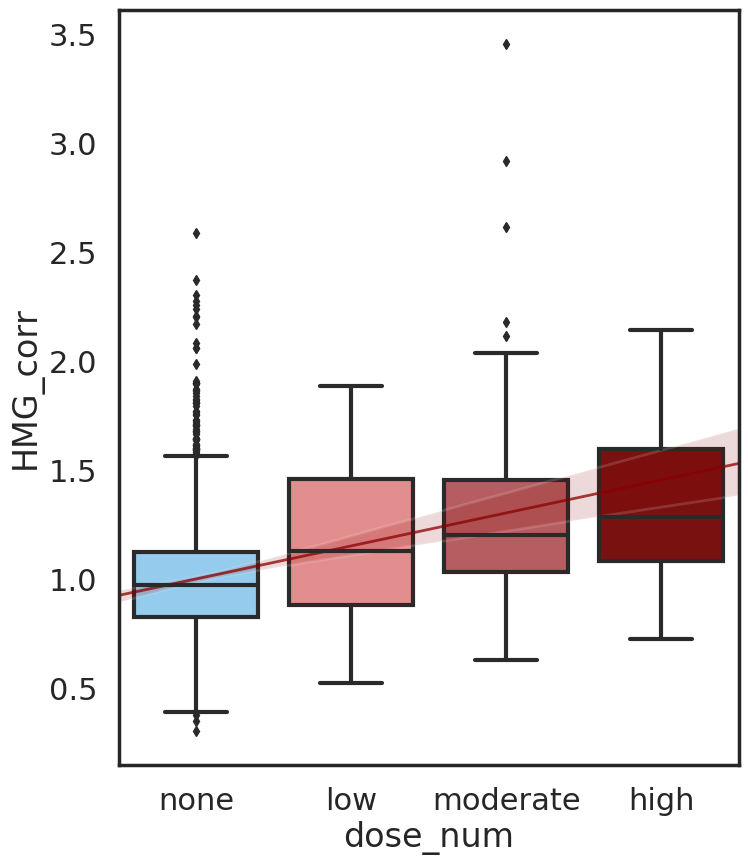

dosage
high          16
low           13
moderate      68
none        1604
dtype: int64

In [302]:
#Association between statin dosage and HMG (Figure 1E)
#generate adj. HMG variable
formula='HMG~BMI+age+age_sq+sex'
plot_df['HMG_corr']=sm.GLM.from_formula(formula, data=plot_df, family=sm.families.Gamma(link=sm.families.links.log())).fit().resid_pearson+plot_df['HMG'].mean()
#generate plot for Figure 1E
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,10], dpi=100)
my_pal = {"none": "lightskyblue", "low": "lightcoral", "moderate":"r","high":"darkred"}
ax=sns.boxplot(plot_df['dosage'],plot_df['HMG_corr'],palette=my_pal,order=['none','low','moderate','high'])
ax = sns.regplot(plot_df['dose_num'],plot_df['HMG_corr'],scatter=False,color='darkred',line_kws={'linewidth':2,'alpha':0.75}); 
plt.show()
#print number of samples in each dosage group
plot_df[plot_df['HMG_corr'].isnull()==False].groupby(by='dosage').size()

In [303]:
#Association between statin dosage and LDL (Figure 1E)
model=smf.ols('LDL~BMI+age+age_sq+sex+chem_vendor+dose_num',data=plot_df).fit()
print('Beta(95%CI)',model.params[6],"(",model.conf_int()[6:7][0].tolist(),model.conf_int()[6:7][1].tolist(),")")
print('P-value=',model.pvalues[6])

Beta(95%CI) -14.914905795904348 ( [-18.078134868363176] [-11.75167672344552] )
P-value= 6.6608479019833e-20


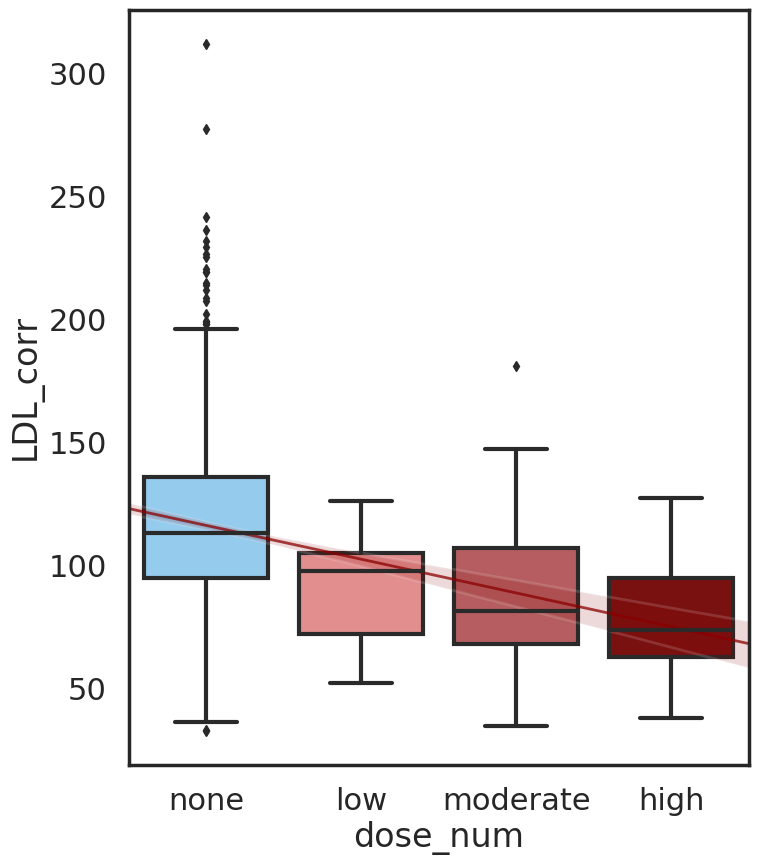

dosage
high          16
low           13
moderate      68
none        1604
dtype: int64

In [304]:
#generate adj. LDL variable for Fig.1D
plot_df['LDL_corr']=smf.ols('LDL~BMI+age+age_sq+sex+chem_vendor',data=plot_df).fit().resid+plot_df['LDL'].mean()
#generate plot for Figure 1E
#plot association
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,10], dpi=100)
my_pal = {"none": "lightskyblue", "low": "lightcoral", "moderate":"r","high":"darkred"}
ax=sns.boxplot(plot_df['dosage'],plot_df['LDL_corr'],palette=my_pal,order=['none','low','moderate','high'])
ax = sns.regplot(plot_df['dose_num'],plot_df['LDL_corr'],scatter=False,color='darkred',line_kws={'linewidth':2,'alpha':0.75}); 
plt.show()
#print number of samples per group
plot_df[plot_df['LDL_corr'].isnull()==False].groupby(by='dosage').size()

statin association with Shannon
p-value 0.005129339855463466
Beta-Coef -0.09466530131478115
95%CI [-0.1609142963909807] [-0.028416306238581587]


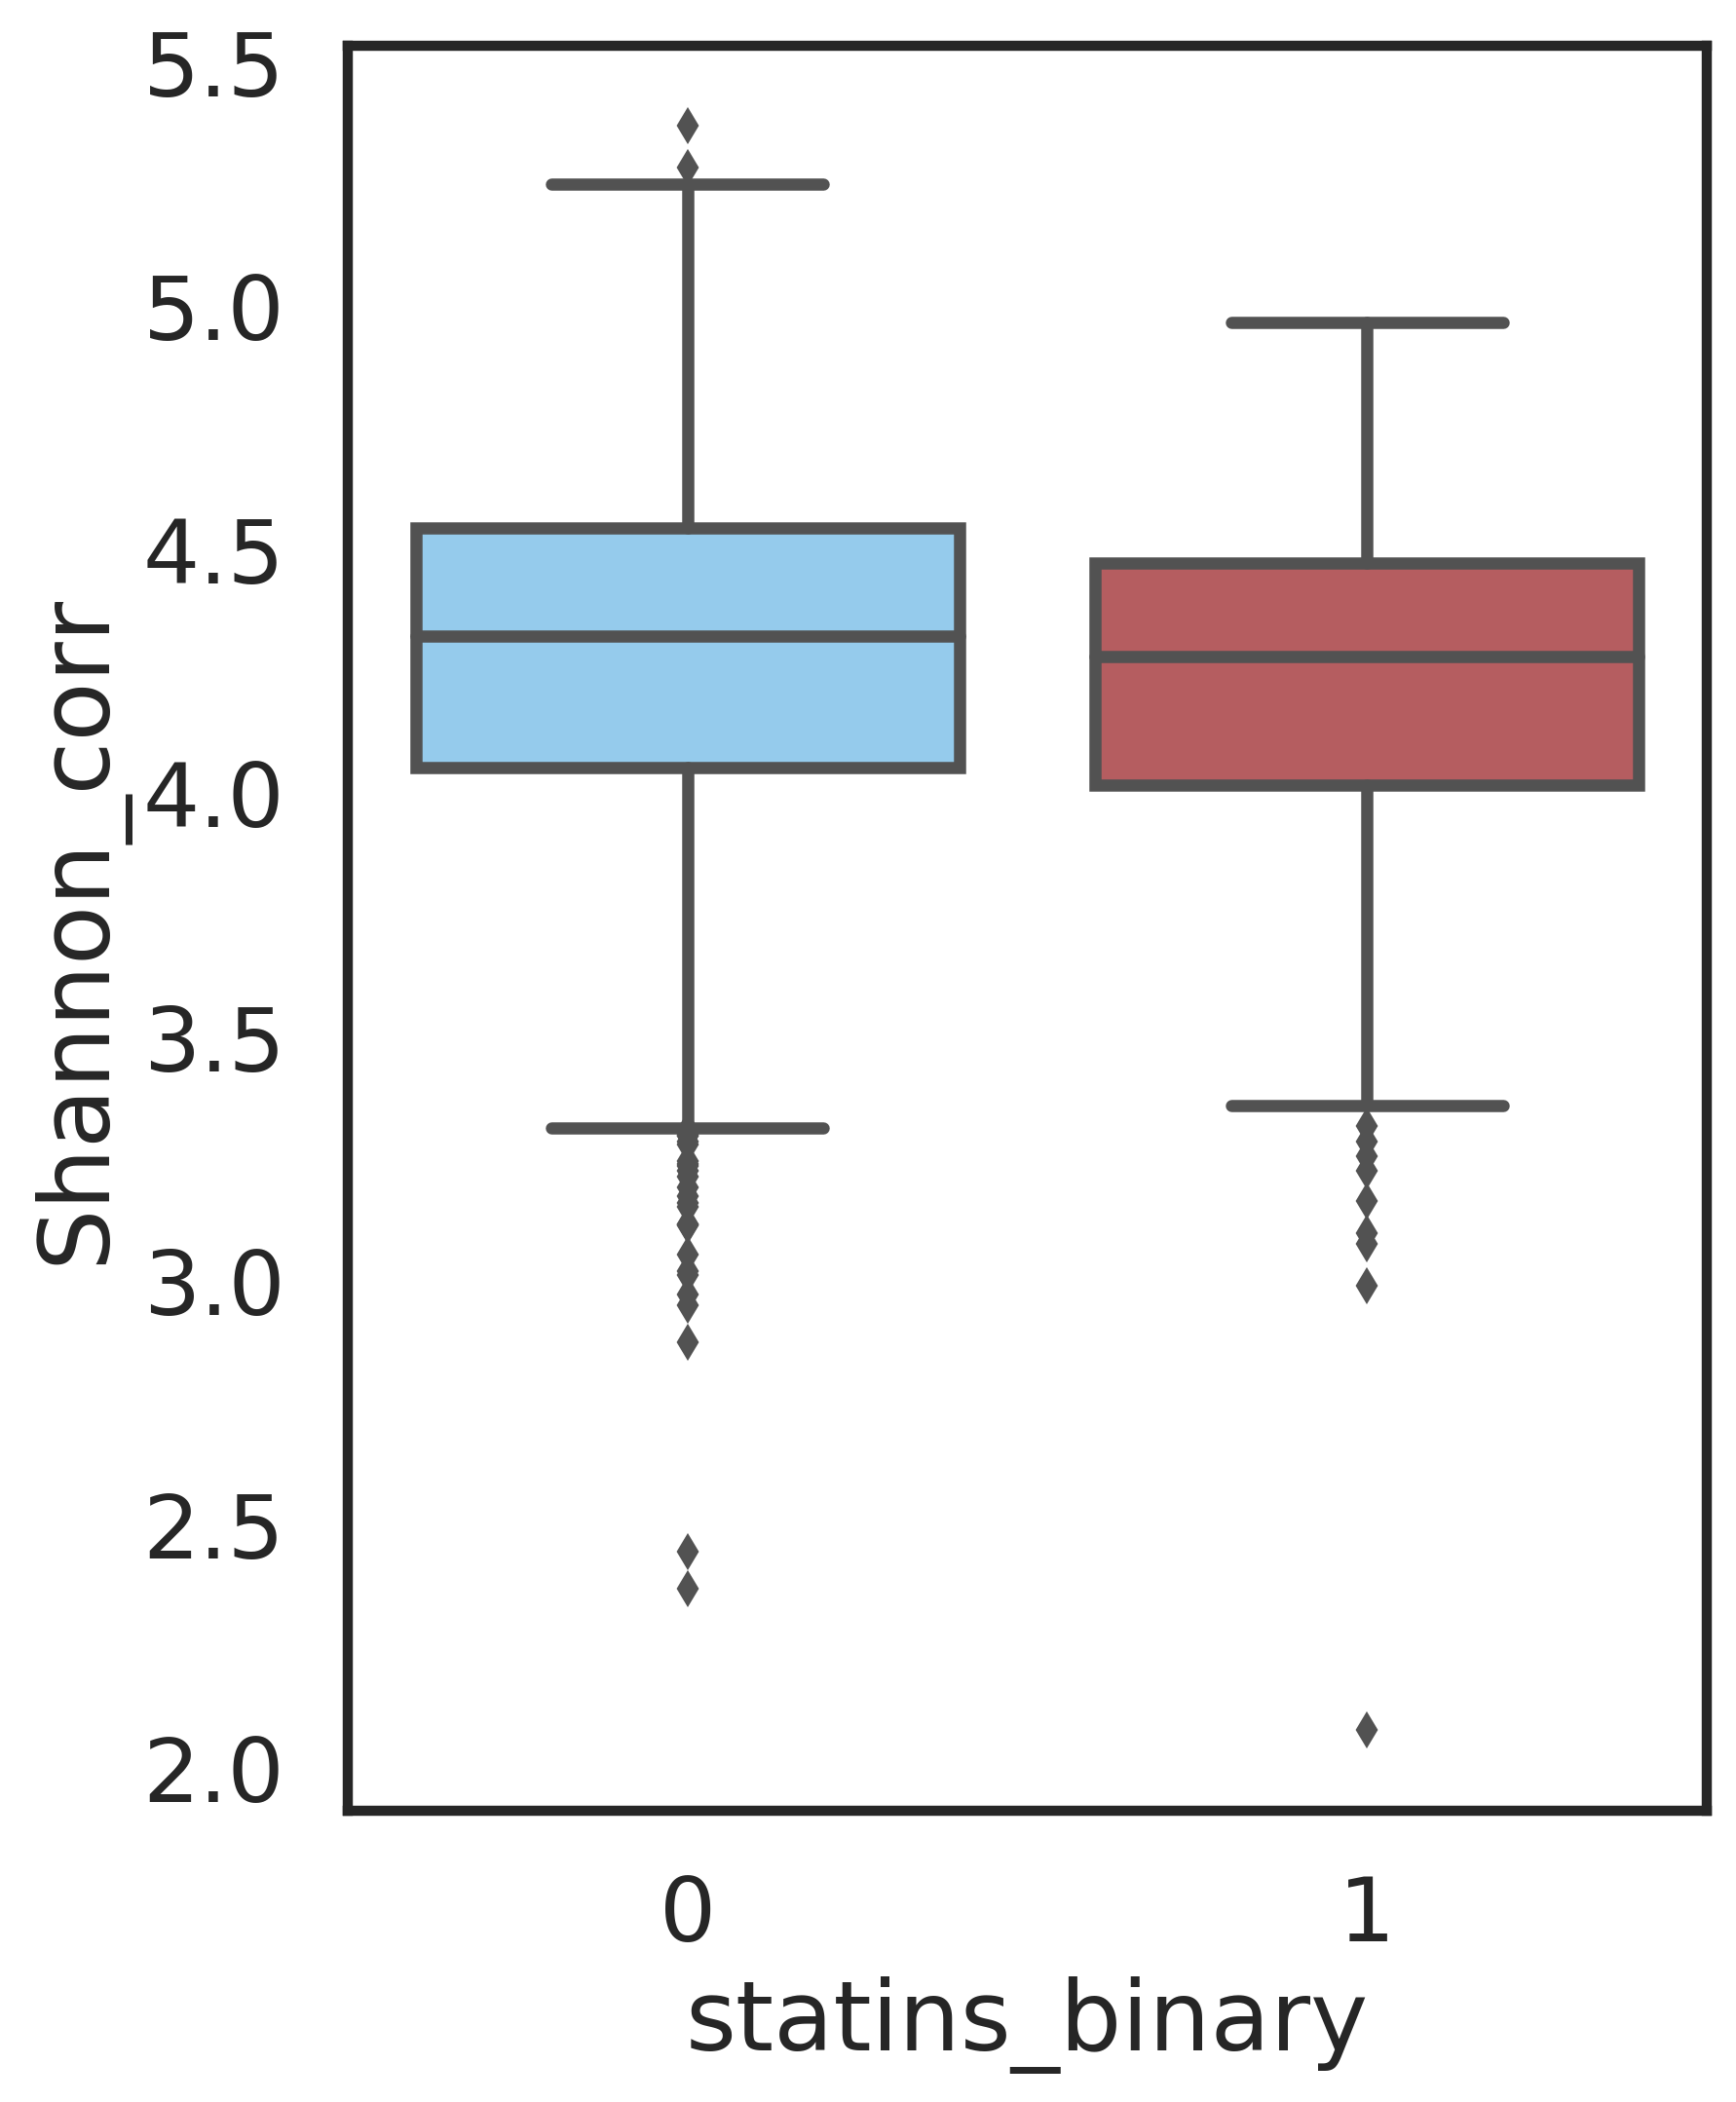

In [305]:
#Figure generation and statistics for Figure 2B
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[6,8], dpi=300)
reg=smf.ols('Shannon~vendor_microbiome+BMI+age+age_sq+sex+statins_binary',data=df).fit()
print('statin association with Shannon')
print('p-value',reg.pvalues[6])
print('Beta-Coef',reg.params[6])
print('95%CI',reg.conf_int()[6:7][0].tolist(),reg.conf_int()[6:7][1].tolist())
#generate adjusted Shannon variable
df['Shannon_corr']=smf.ols('Shannon~vendor_microbiome+BMI+age+age_sq+LDL+sex',data=df).fit().resid+df['Shannon'].mean()
my_pal = {0: "lightskyblue", 1:"r"}
ax=sns.boxplot(df['statins_binary'],df['Shannon_corr'],palette=my_pal,order=[0,1])
plt.show()

0.10508637419934187
-12.668674455959145
95%CI [-27.99259190199994] [2.65524299008165]


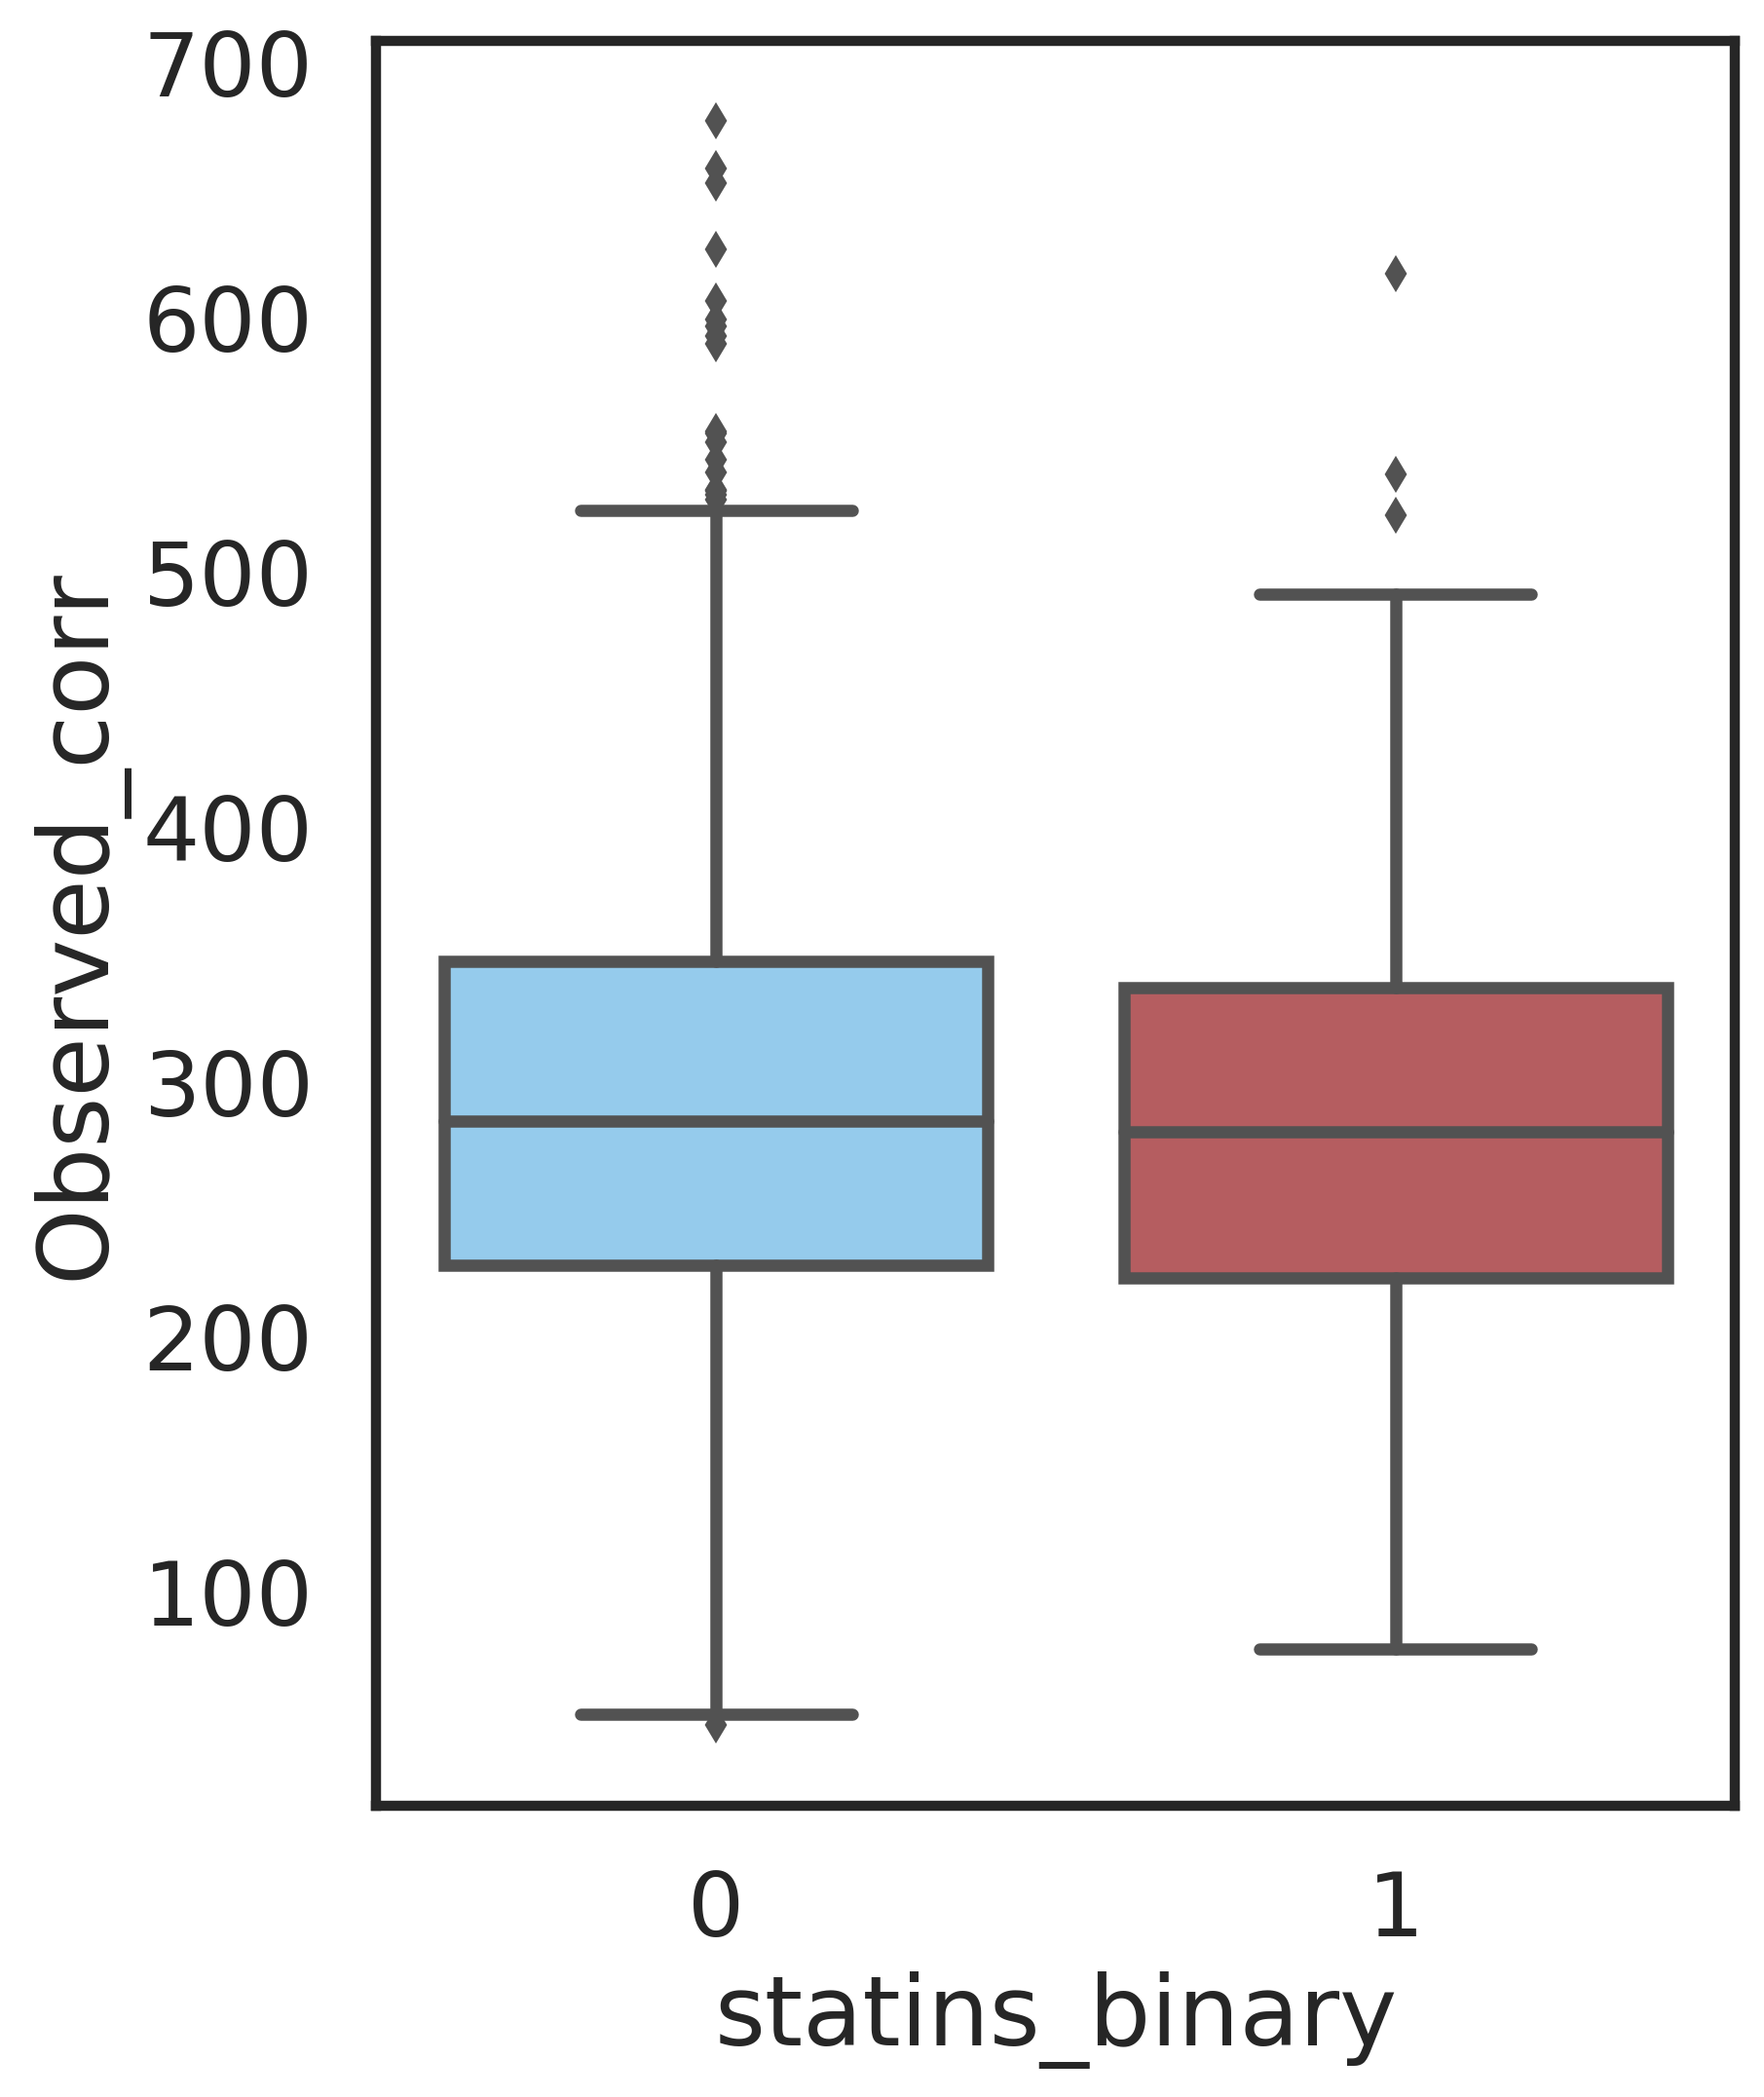

In [306]:
#Figure generation and statistics for Figure 2B continued...
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[6,8], dpi=300)
reg=smf.ols('Observed~vendor_microbiome+BMI+age+age_sq+sex+statins_binary',data=df).fit()
print(reg.pvalues[6])
print(reg.params[6])
print('95%CI',reg.conf_int()[6:7][0].tolist(),reg.conf_int()[6:7][1].tolist())
df['Observed_corr']=smf.ols('Observed~vendor_microbiome+BMI+age+age_sq+sex',data=df).fit().resid+df['Observed'].mean()
my_pal = {0: "lightskyblue", 1:"r"}
ax=sns.boxplot(df['statins_binary'],df['Observed_corr'],palette=my_pal,order=[0,1])
plt.show()

-0.28849351310424537
                                                           0         1
C(dosage, Treatment(reference="none"))[T.moderate] -0.408325 -0.168662
2.56400263825907e-06


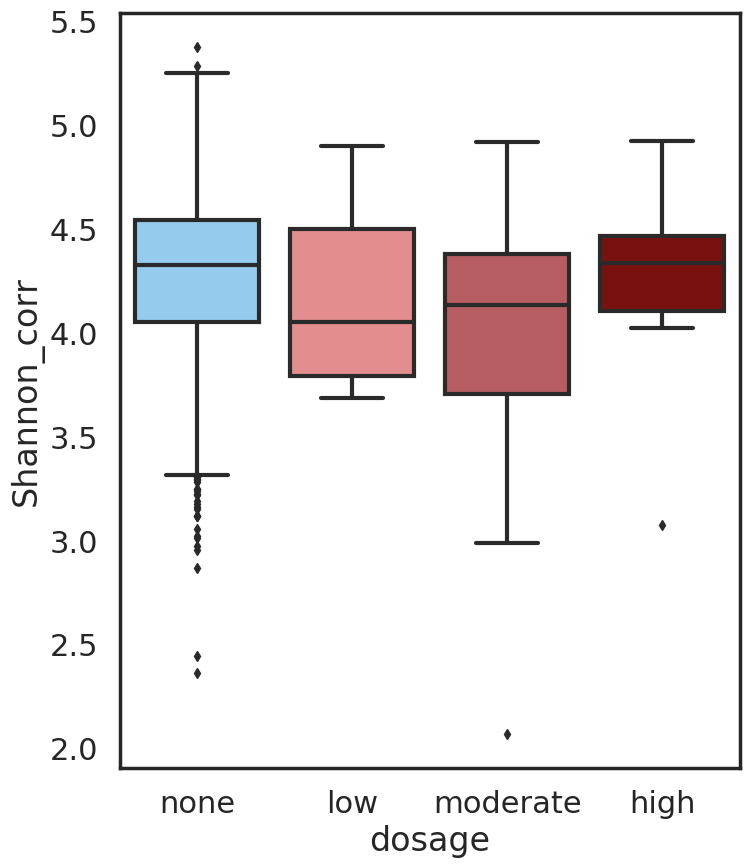

In [307]:
#Figure generation and statistics for Figure 2C
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,10], dpi=100)
reg_dose=smf.ols('Shannon~vendor_microbiome+BMI+age+sex+age_sq+C(dosage,Treatment(reference="none"))',data=plot_df).fit()
print(reg_dose.params[3])
print(reg_dose.conf_int()[3:4])
print(reg_dose.pvalues[3])
plot_df['Shannon_corr']=smf.ols('Shannon~vendor_microbiome+BMI+age+age_sq+sex',data=df).fit().resid+df['Shannon'].mean()
my_pal = {"none": "lightskyblue", "low": "lightcoral", "moderate":"r","high":"darkred"}
ax=sns.boxplot(plot_df['dosage'],plot_df['Shannon_corr'],palette=my_pal,order=['none','low','moderate','high'])
plt.show()

In [70]:
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,10], dpi=100)
reg_dose=smf.ols('Observed~vendor_microbiome+BMI+age+sex+age_sq+C(dosage,Treatment(reference="none"))',data=plot_df).fit()
print(reg_dose.params[3])
print(reg_dose.conf_int()[3:4])
print(reg_dose.pvalues[3])
plot_df['Observed_corr']=smf.ols('Observed~vendor_microbiome+BMI+age+sex+age_sq',data=plot_df).fit().resid+plot_df['Observed'].mean()
my_pal = {"none": "lightskyblue", "low": "lightcoral", "moderate":"r","high":"darkred"}
ax=sns.boxplot(plot_df['dosage'],plot_df['Observed_corr'],palette=my_pal,order=['none','low','moderate','high'])
plt.show()
plot_df[plot_df['Shannon'].isnull()==False].groupby(by='dosage').size()

NameError: name 'plot_df' is not defined

<Figure size 800x1000 with 0 Axes>

In [309]:
#Shannon*statin interaction predicting HMG from Figure 2D
print('Shannon*statin interaction predicting HMG')
formula='HMG~vendor_microbiome+BMI+age+age_sq+sex+Shannon*statins_binary'
model=sm.GLM.from_formula(formula, data=df, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print('Beta-Coef',model.params[8])
print('p-value',model.pvalues[8])
print(model.conf_int()[8:9])

Shannon*statin interaction predicting HMG
Beta-Coef -0.15281590841925793
p-value 0.0014142674522222996
                               0         1
Shannon:statins_binary -0.246657 -0.058975


In [310]:
#Observed ASVs*statin interaction predicting HMG from Figure 2D
print('Observed*statin interaction predicting HMG')
formula='HMG~vendor_microbiome+BMI+age+age_sq+sex+Observed*statins_binary'
model=sm.GLM.from_formula(formula, data=df, family=sm.families.Gamma(link=sm.families.links.log())).fit()
print('Beta-Coef',model.params[8])
print('p-value',model.pvalues[8])
print(model.conf_int()[8:9])

Observed*statin interaction predicting HMG
Beta-Coef -0.0005978563272493566
p-value 0.0032825581171957315
                                0         1
Observed:statins_binary -0.000996 -0.000199


Shannon_quant   statins_binary
(1.856, 4.136]  0                 432
                1                  72
(4.136, 4.465]  0                 438
                1                  66
(4.465, 5.514]  0                 445
                1                  59
dtype: int64

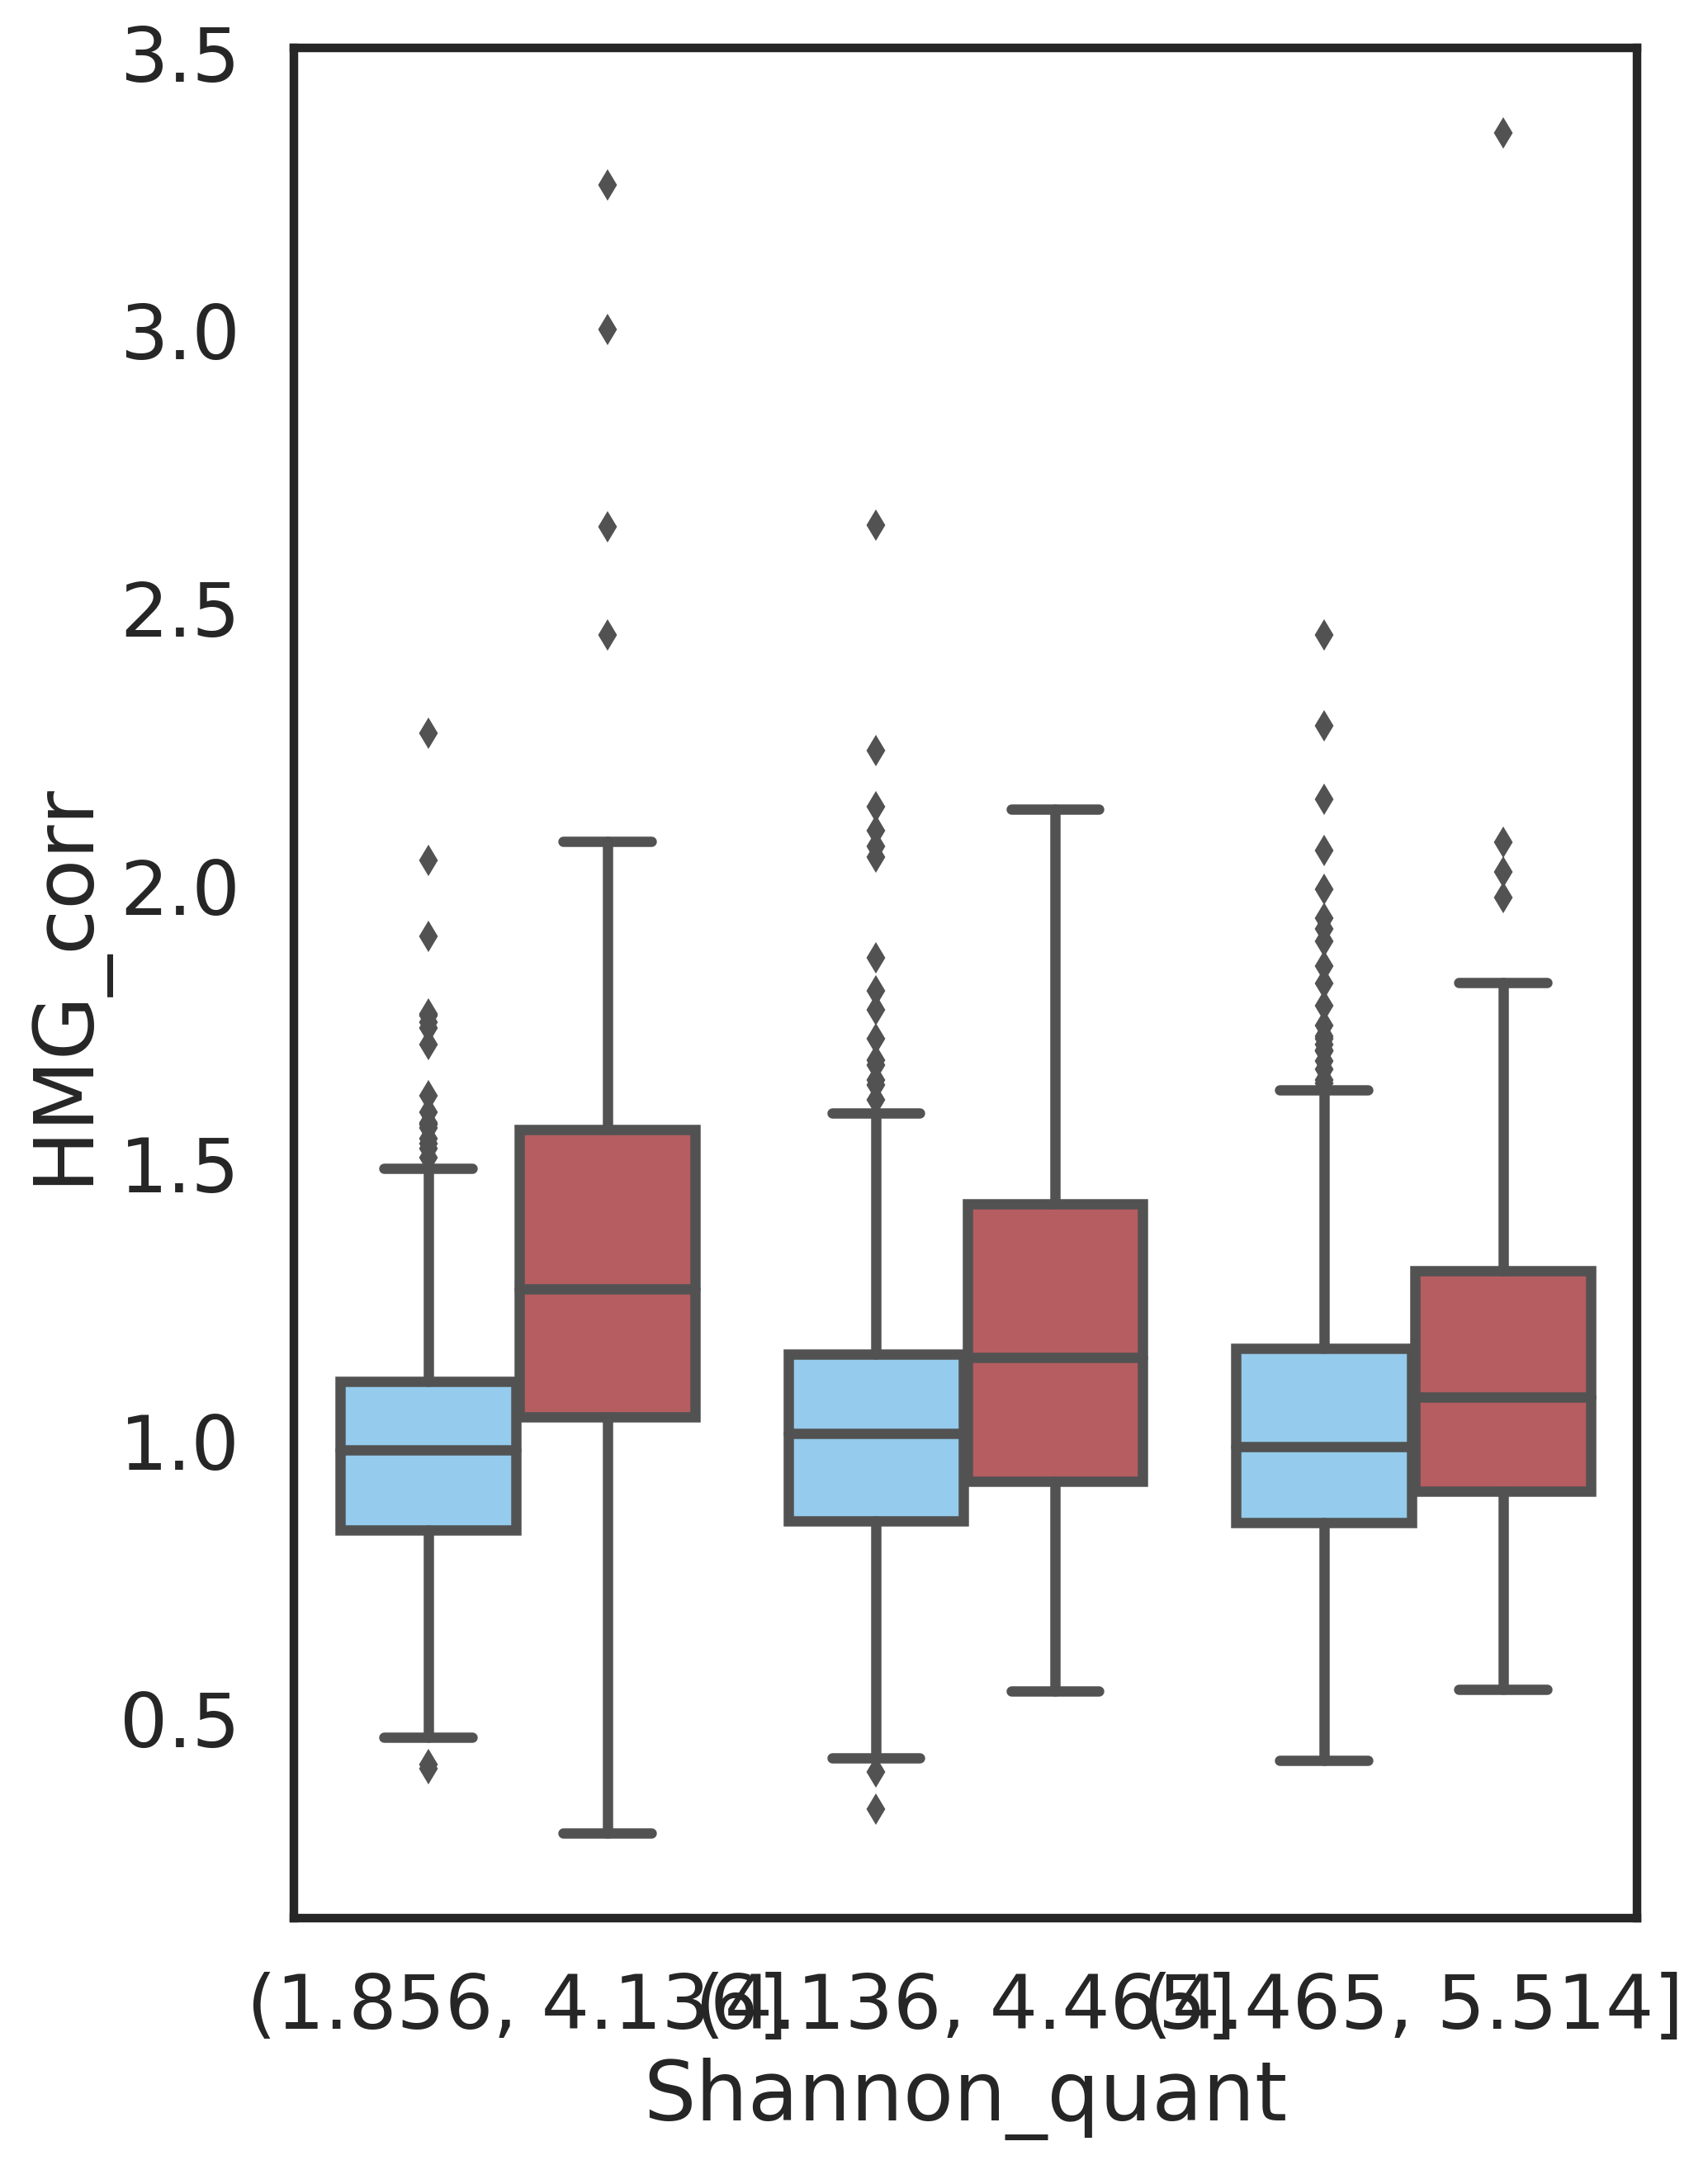

In [311]:
#plotting Shannon-statin interactions Figure 2D
formula='HMG~vendor_microbiome+BMI+age+age_sq+sex'
#split cohort into tertiles of Shannon diversity
df['Shannon_quant']=pd.qcut(df['Shannon'],3)
df['HMG_corr']=sm.GLM.from_formula(formula, data=df, family=sm.families.Gamma(link=sm.families.links.log())).fit().resid_pearson+df['HMG'].mean()
#plot the boxplots
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[7,10], dpi=300)
my_pal = {0: "lightskyblue", 1: "r"}
ax=sns.boxplot(df['Shannon_quant'],(df['HMG_corr']),hue=df['statins_binary'],palette=my_pal)
ax.legend_.remove()
#check number of samples in each group
df.groupby(['Shannon_quant','statins_binary']).size()

Obs_quant           statins_binary
(8.999, 234.667]    0                 434
                    1                  70
(234.667, 319.333]  0                 440
                    1                  64
(319.333, 723.0]    0                 441
                    1                  63
dtype: int64

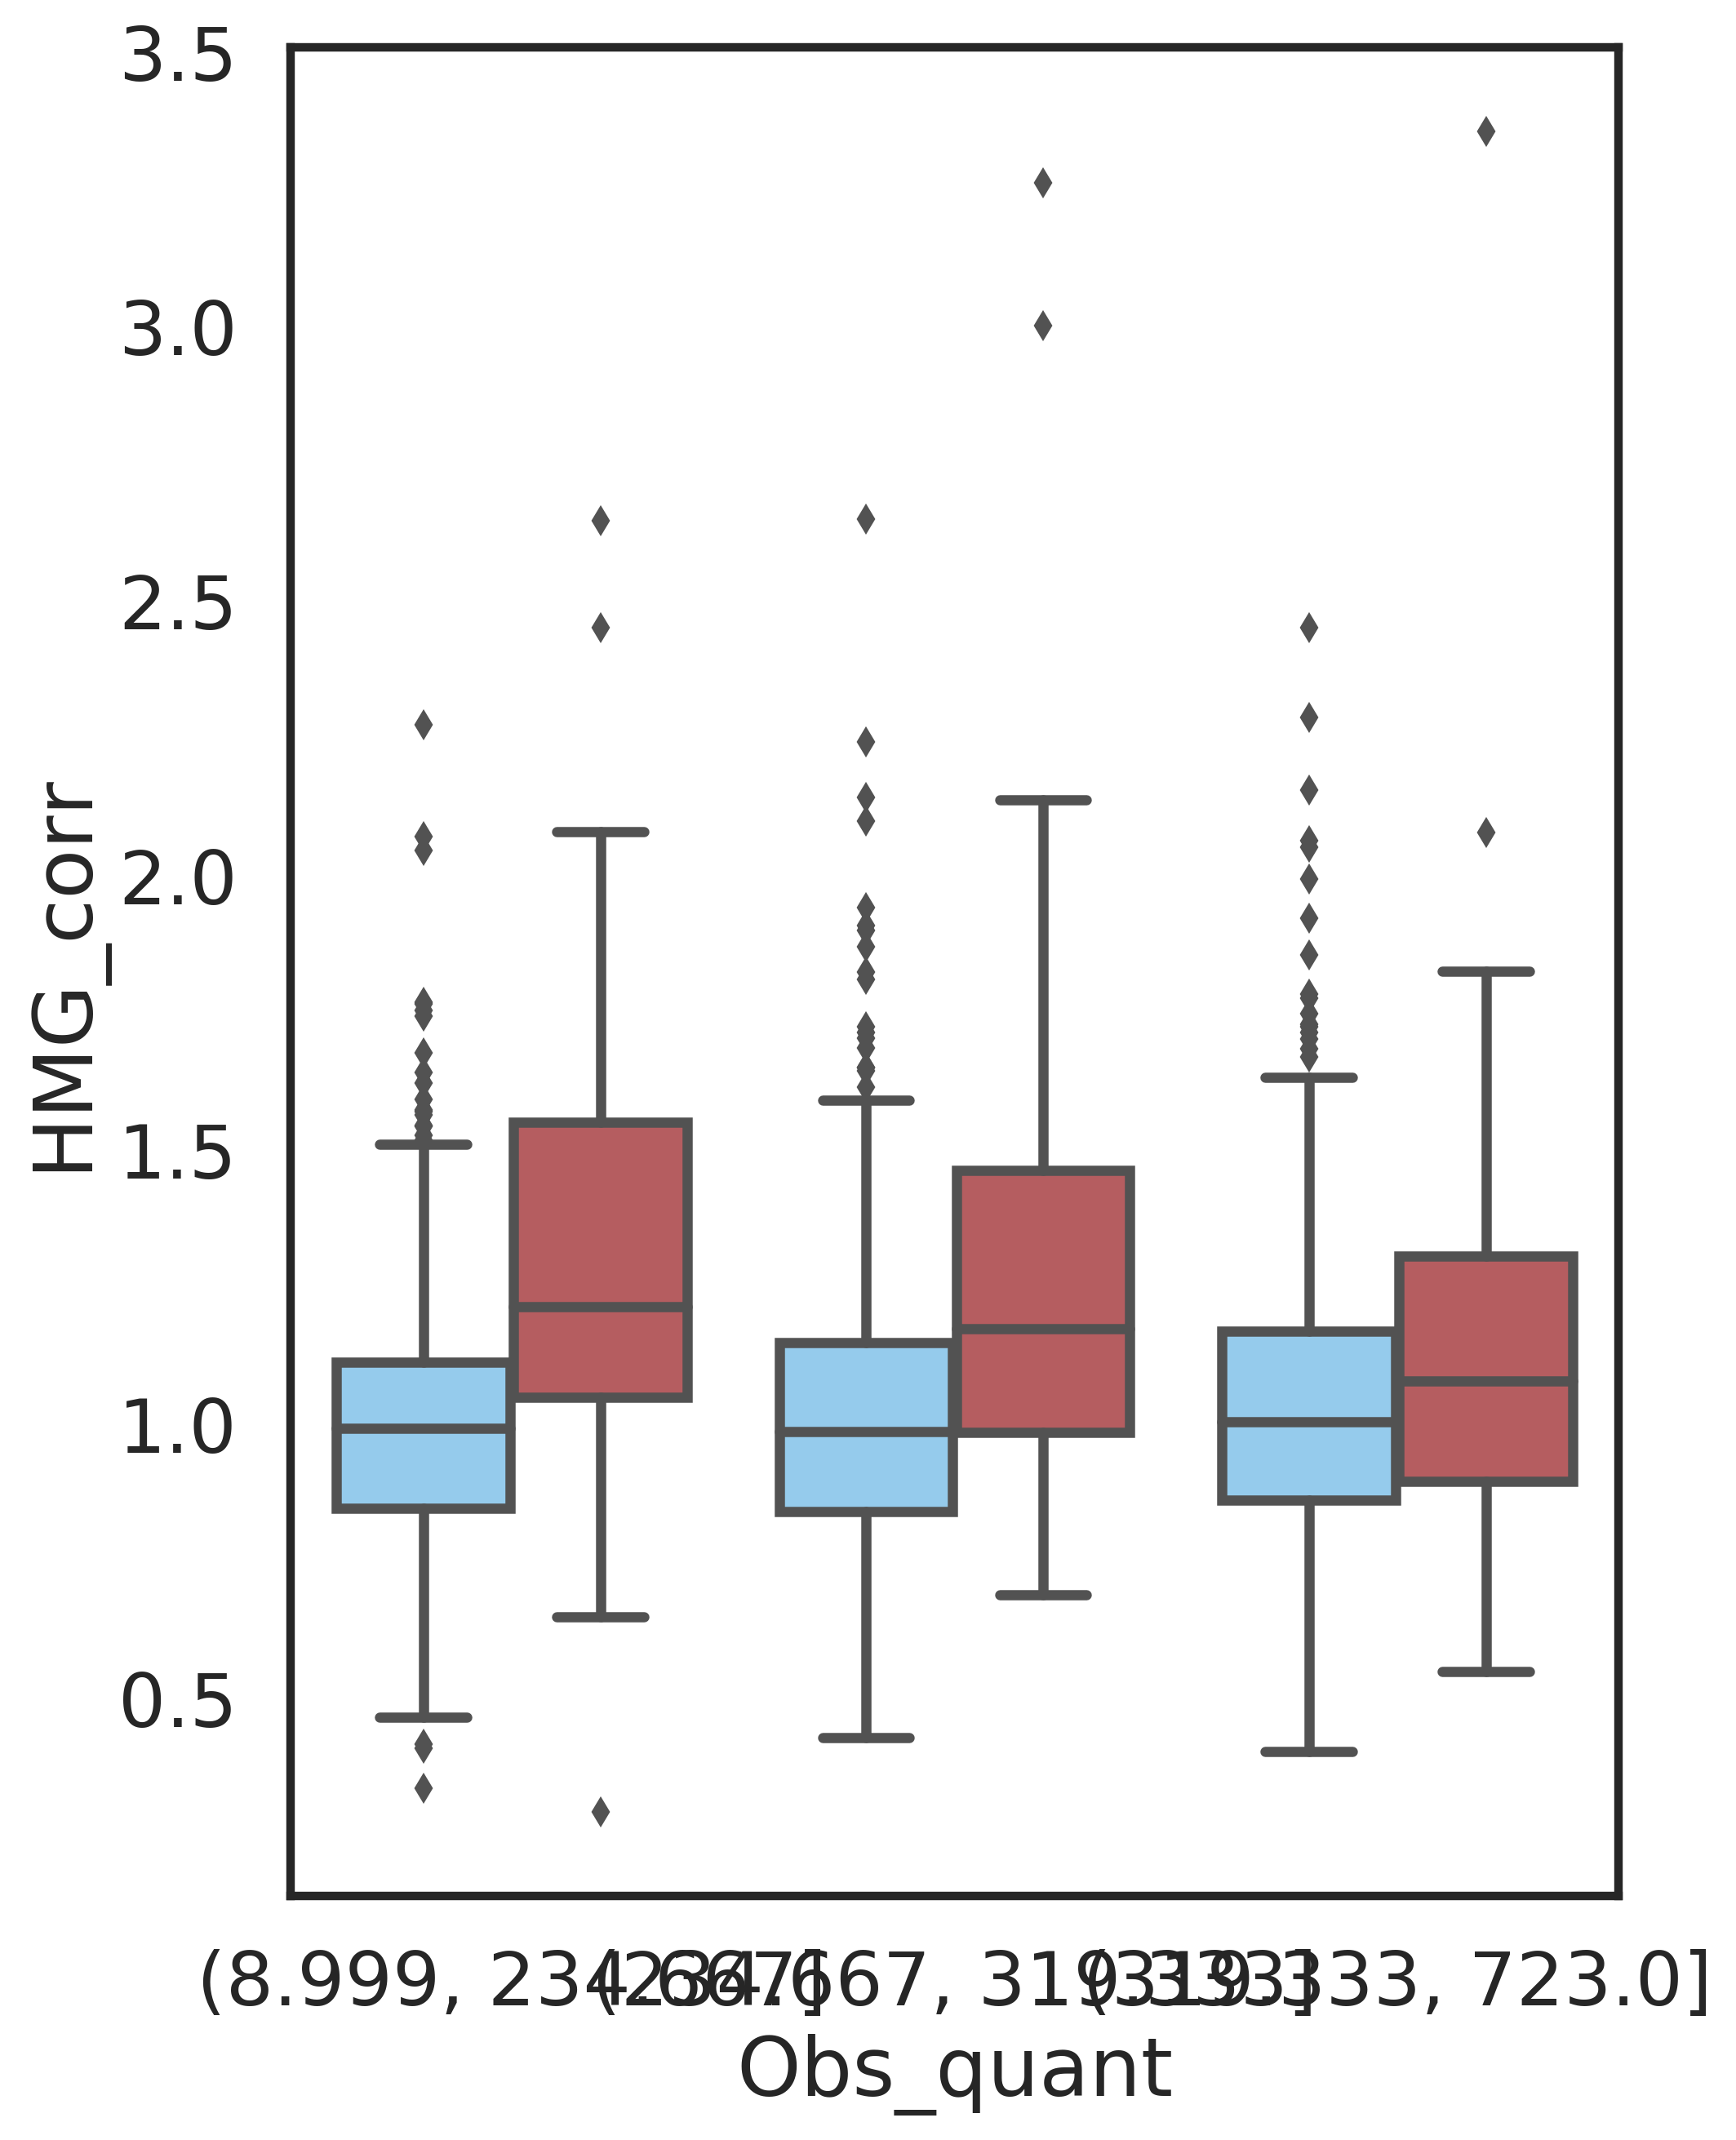

In [312]:
#plotting Observed ASVs-statin interactions Figure 2D
formula='HMG~vendor_microbiome+BMI+age+age_sq+sex'
df['Obs_quant']=pd.qcut(df['Observed'],3)
df['HMG_corr']=sm.GLM.from_formula(formula, data=df, family=sm.families.Gamma(link=sm.families.links.log())).fit().resid_pearson+df['HMG'].mean()
#plot the boxplot
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[7,10], dpi=300)
my_pal = {0: "lightskyblue", 1: "r"}
ax=sns.boxplot(df['Obs_quant'],(df['HMG_corr']),hue=df['statins_binary'],palette=my_pal)
ax.legend_.remove()
#check no. of individuals per group
df.groupby(['Obs_quant','statins_binary']).size()

(1315, 33)
correlation statin users OBSERVED ASVs SpearmanrResult(correlation=-0.41026261281268495, pvalue=0.00025655151987975854)
correlation non-users OBSERVED ASVs SpearmanrResult(correlation=0.022777482771399474, pvalue=0.4092014010562556)
correlation statin users Shannon SpearmanrResult(correlation=-0.34617354196301564, pvalue=0.002348125511874955)
correlation non-users Shannon SpearmanrResult(correlation=0.050015306542740924, pvalue=0.06981462886688314)


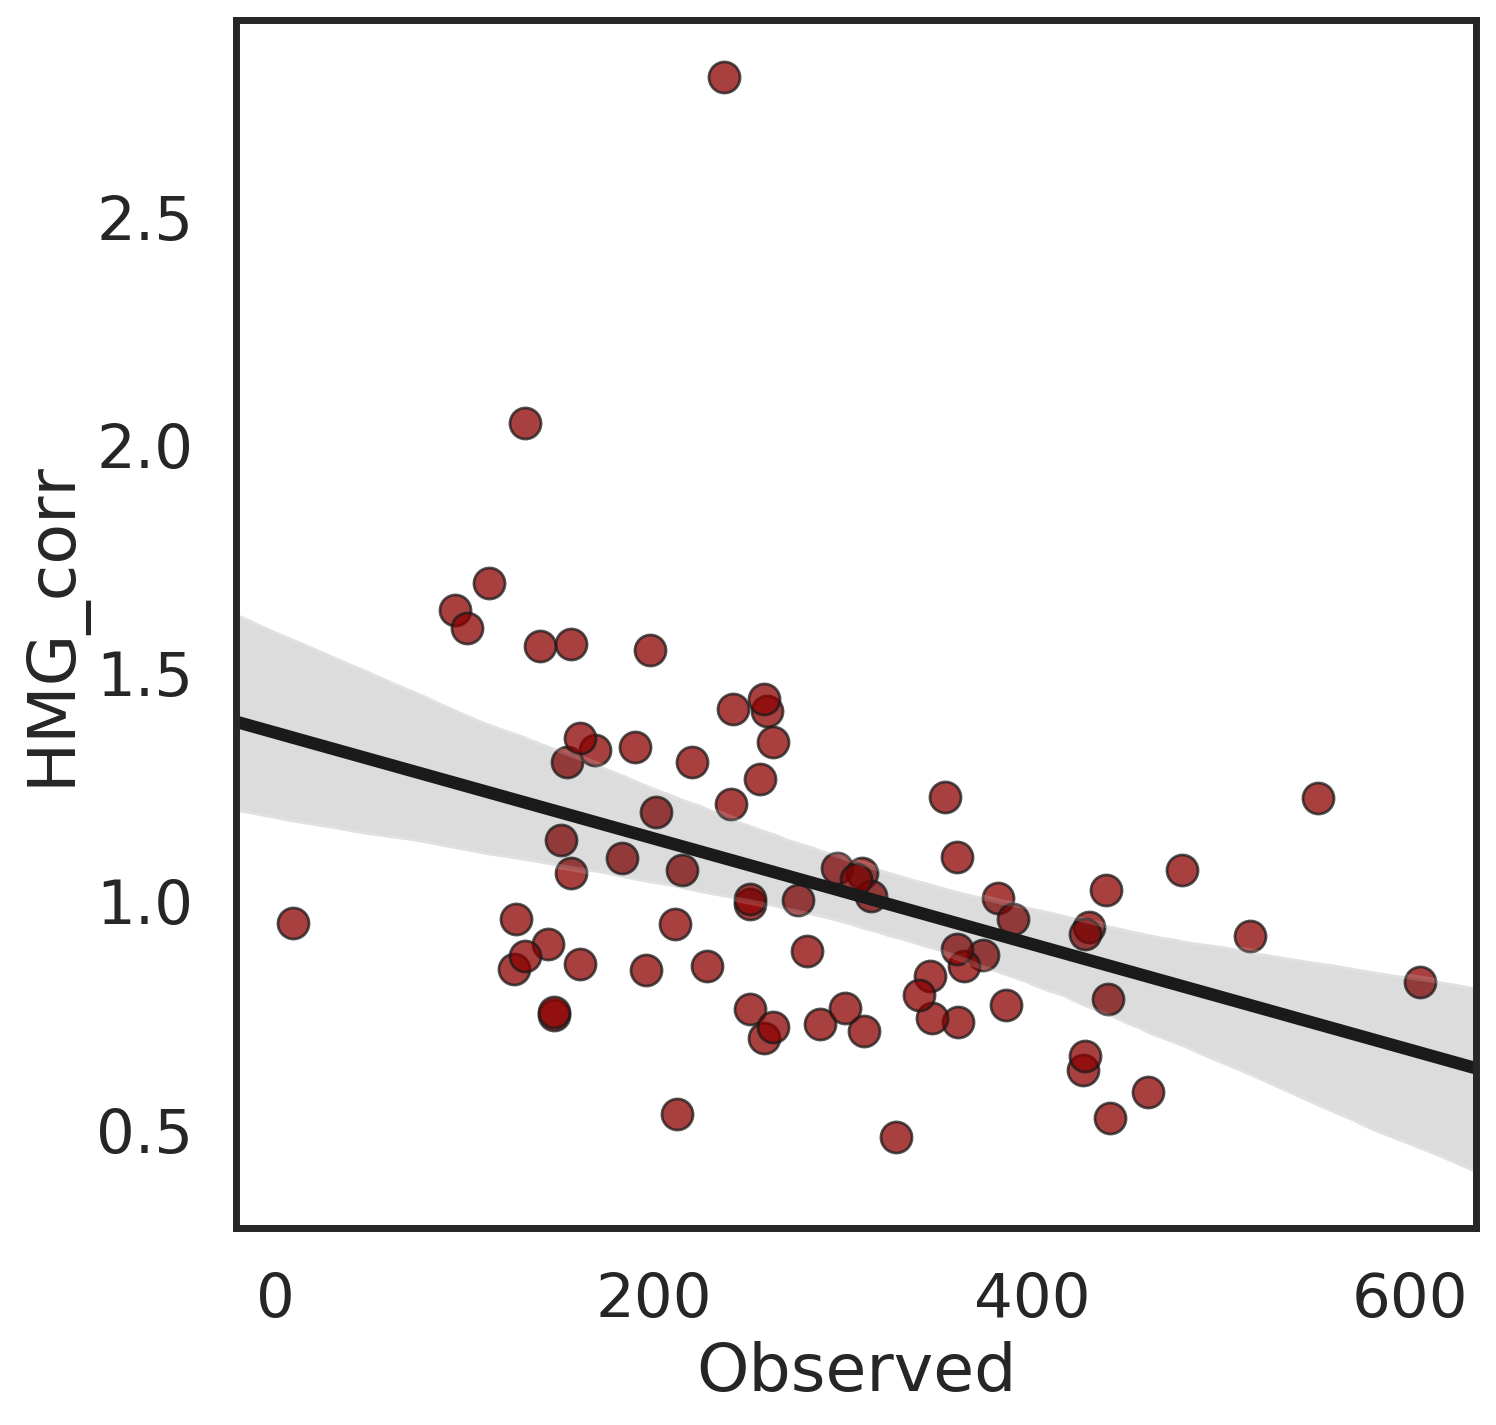

In [313]:
#statistics and visualization for Figure 2E
formula='HMG~vendor_microbiome+BMI+age+age_sq+sex+dose_num'
plot_df['HMG_corr']=sm.GLM.from_formula(formula, data=plot_df, family=sm.families.Gamma(link=sm.families.links.log())).fit().resid_pearson+plot_df['HMG'].mean()
plot_df['LDL_corr']=smf.ols('LDL~vendor_microbiome+chem_vendor+BMI+age+age_sq+sex+dose_num',data=plot_df).fit().resid+plot_df['LDL'].mean()
sns.set(font_scale=1.,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,8], dpi=200)
#plot scatter of HMG by Observed ASVs in statin users with known therapy intensity
sns.regplot(plot_df['Observed'][plot_df['statins_binary']==1],plot_df['HMG_corr'][plot_df['statins_binary']==1],scatter_kws={'s':125,'alpha': 0.75,'edgecolor':'k'},line_kws={'color':'k'},color='darkred')
d=plot_df[plot_df['Observed'].isnull()==False]
d=d[d['HMG_corr'].isnull()==False]
print(d[d['statins_binary']==0].shape)
print('correlation statin users OBSERVED ASVs',scipy.stats.spearmanr(d['Observed'][d['statins_binary']==1],d['HMG_corr'][d['statins_binary']==1]))
print('correlation non-users OBSERVED ASVs',scipy.stats.spearmanr(d['Observed'][d['statins_binary']==0],d['HMG_corr'][d['statins_binary']==0]))
print('correlation statin users Shannon',scipy.stats.spearmanr(d['Shannon'][d['statins_binary']==1],d['HMG_corr'][d['statins_binary']==1]))
print('correlation non-users Shannon',scipy.stats.spearmanr(d['Shannon'][d['statins_binary']==0],d['HMG_corr'][d['statins_binary']==0]))

beta-coef 9.223113068276926e-06
95%CI                  0         1
Observed -0.000155  0.000174
p-value 0.912501482769394


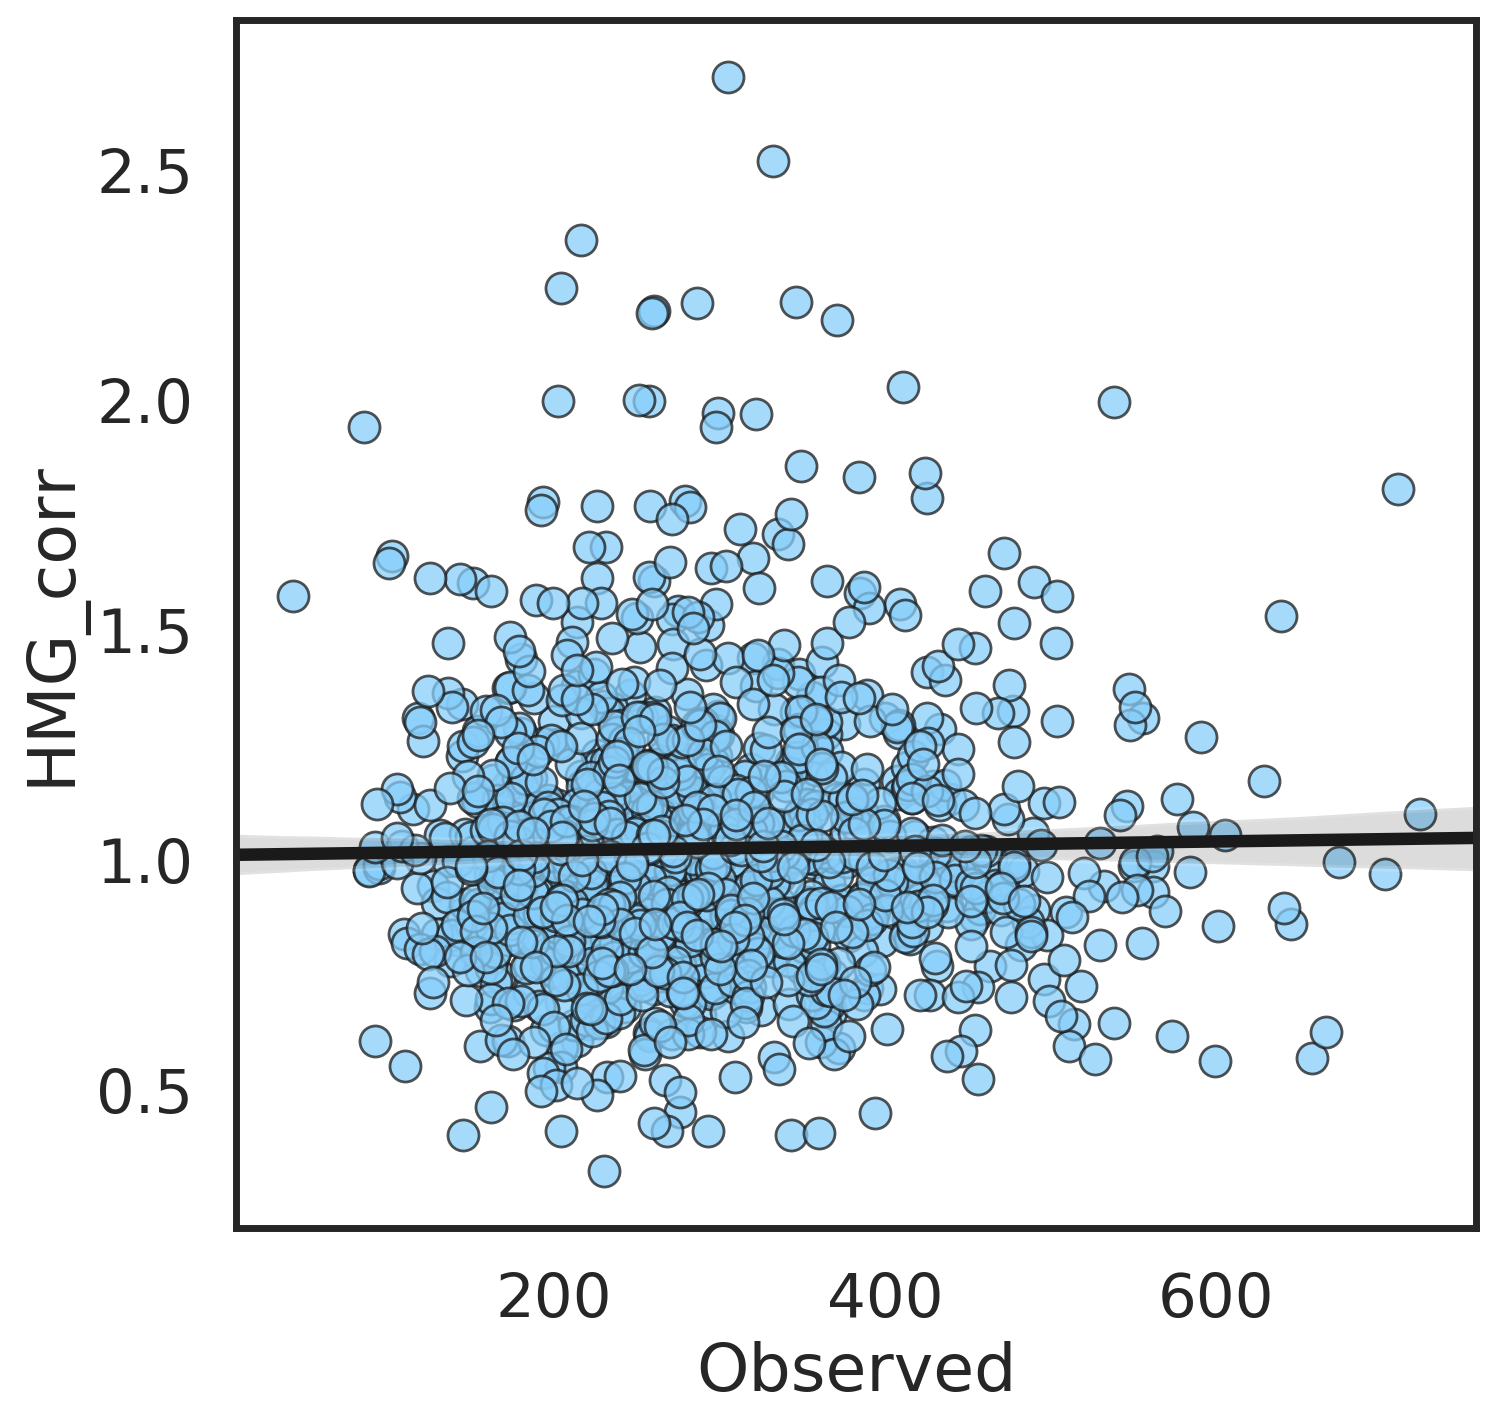

In [314]:
sns.set(font_scale=1.,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,8], dpi=200)
sns.regplot(plot_df['Observed'][plot_df['statins_binary']==0],plot_df['HMG_corr'][plot_df['statins_binary']==0],scatter_kws={'s':125,'alpha': 0.75,'edgecolor':'k'},line_kws={'color':'k'},color='lightskyblue')
formula='HMG~vendor_microbiome+BMI+sex+age+age_sq+Observed'
print('beta-coef',sm.GLM.from_formula(formula, data=plot_df[plot_df['statins_binary']==0], family=sm.families.Gamma(link=sm.families.links.log())).fit().params[6])
print('95%CI',sm.GLM.from_formula(formula, data=plot_df[plot_df['statins_binary']==0], family=sm.families.Gamma(link=sm.families.links.log())).fit().conf_int()[6:7])
print('p-value',sm.GLM.from_formula(formula, data=plot_df[plot_df['statins_binary']==0], family=sm.families.Gamma(link=sm.families.links.log())).fit().pvalues[6])

In [315]:
#glm for Figure 1D in statin users
formula='HMG~vendor_microbiome+BMI+sex+age+age_sq+dose_num+Observed'
model=sm.GLM.from_formula(formula, data=plot_df[plot_df['statins_binary']==1], family=sm.families.Gamma(link=sm.families.links.log())).fit()
print('beta-coef',model.params[7])
print('95%CI',model.conf_int()[7:8])
print('p-value',model.pvalues[7])

beta-coef -0.0009562469745898811
95%CI                 0         1
Observed -0.00168 -0.000233
p-value 0.009585755610997707


In [316]:
formula='HMG~vendor_microbiome+BMI+sex+age+age_sq+dose_num+Shannon'
model=sm.GLM.from_formula(formula, data=plot_df[plot_df['statins_binary']==1], family=sm.families.Gamma(link=sm.families.links.log())).fit()
print('beta-coef',model.params[7])
print('95%CI',model.conf_int()[7:8])
print('p-value',model.pvalues[7])

beta-coef -0.14311615739579558
95%CI                 0         1
Shannon -0.294536  0.008304
p-value 0.06395656915216091


In [317]:
#Exploring statin*alpha diversity interactions with LDL cholesterol as the dependent variable
model_LDL=smf.ols('LDL~chem_vendor+vendor_microbiome+BMI+age+age_sq+sex+Shannon*statins_binary',data=df).fit()
print('Shannon-by-statins interaction p-value',model_LDL.pvalues[9])
print('Shannon-by-statins interaction Beta',model_LDL.params[9],'95%CI',model_LDL.conf_int()[9:10])
model_LDL=smf.ols('LDL~chem_vendor+vendor_microbiome+BMI+age+age_sq+sex+Observed*statins_binary',data=df).fit()
print('Observed ASVs-by-statins interaction p-value',model_LDL.pvalues[9])
print('Observed ASVs-by-statins interaction Beta',model_LDL.params[9],'95%CI',model_LDL.conf_int()[9:10])


Shannon-by-statins interaction p-value 0.014302245836945789
Shannon-by-statins interaction Beta 12.248525630197971 95%CI                                0          1
Shannon:statins_binary  2.451734  22.045317
Observed ASVs-by-statins interaction p-value 0.04547227862515057
Observed ASVs-by-statins interaction Beta 0.04246507531459984 95%CI                                 0         1
Observed:statins_binary  0.000857  0.084074


(197, 34)
(1315, 34)
correlation statin users LDL-Shannon SpearmanrResult(correlation=0.17698846959180536, pvalue=0.012845772730012054)
correlation statin users LDL-Shannon SpearmanrResult(correlation=-0.035712003321686, pvalue=0.1955952754044488)
                0          1
Shannon  1.693784  19.923982
10.808882987974535
0.02037258598252956


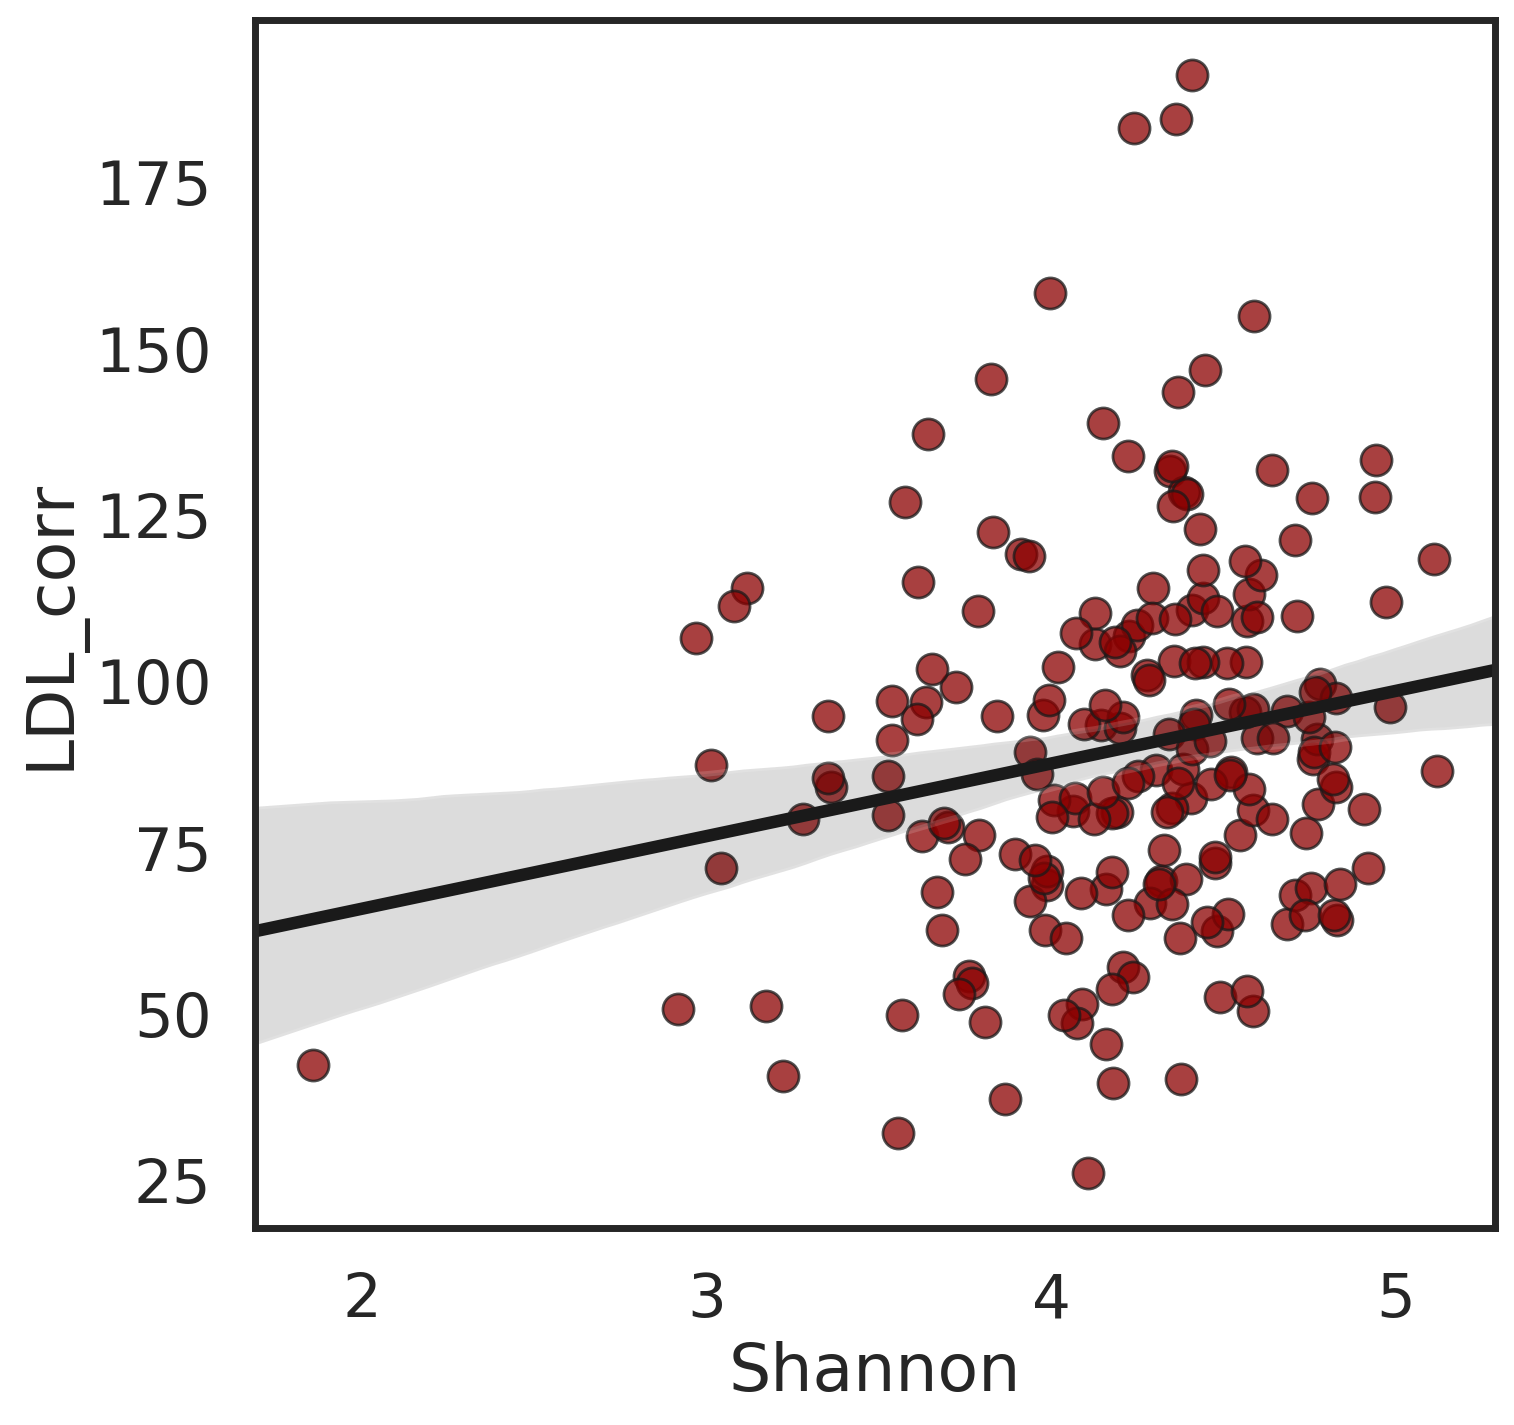

In [318]:
#plotting LDL as a function of Shannon diversity in statin users
#adjusted LDL across all statin users
df['LDL_corr']=smf.ols('LDL~chem_vendor+vendor_microbiome+BMI+age+age_sq+sex',data=df).fit().resid+df['LDL'].mean()
#adjusted LDL across all statin users with known intensity (dose_num)
plot_df['LDL_corr']=smf.ols('LDL~chem_vendor+vendor_microbiome+BMI+age+age_sq+sex+dose_num',data=plot_df).fit().resid+plot_df['LDL'].mean()
qf=df[df['LDL_corr'].isnull()==False]
qf=qf[qf['Shannon'].isnull()==False]
print(qf[qf['statins_binary']==1].shape)
d=df[df['Shannon'].isnull()==False]
d=d[d['LDL_corr'].isnull()==False]
print(d[d['statins_binary']==0].shape)
sns.set(font_scale=1.,context='poster',font='Arial',style='white')
plt.figure(figsize=[8,8], dpi=200)
print('correlation statin users LDL-Shannon',scipy.stats.spearmanr(d['Shannon'][d['statins_binary']==1],d['LDL_corr'][d['statins_binary']==1]))
print('correlation statin users LDL-Shannon',scipy.stats.spearmanr(qf['Shannon'][qf['statins_binary']==0],qf['LDL_corr'][qf['statins_binary']==0]))
sns.regplot(qf['Shannon'][qf['statins_binary']==1],qf['LDL_corr'][qf['statins_binary']==1],scatter_kws={'s':125,'alpha': 0.75,'edgecolor':'k'},line_kws={'color':'k'},color='darkred')
reg=smf.ols('LDL~chem_vendor+vendor_microbiome+BMI+age+age_sq+sex+Shannon',data=df[df['statins_binary']==1]).fit()
print(reg.conf_int()[7:8])
print(reg.params[7])
print(reg.pvalues[7])

unadjusted ANOVA                                            sum_sq      df           F  \
Intercept                                5.744821     1.0   66.786781   
C(entero, Sum)                           0.746716     3.0    2.893665   
C(statins_binary, Sum)                  10.103529     1.0  117.459217   
C(entero, Sum):C(statins_binary, Sum)    0.698138     3.0    2.705416   
Residual                               129.370077  1504.0         NaN   

                                             PR(>F)  
Intercept                              6.351839e-16  
C(entero, Sum)                         3.418699e-02  
C(statins_binary, Sum)                 2.092544e-26  
C(entero, Sum):C(statins_binary, Sum)  4.404665e-02  
Residual                                        NaN  
Adjusted ANCOVA model


,sum_sq,df,F,PR(>F)
Intercept,0.429142,1.0,5.538997,1.872585e-02
chem_vendor,3.919026,1.0,50.583405,1.762866e-12
"C(entero, Sum)",0.424758,3.0,1.827471,1.401881e-01
"C(statins_binary, Sum)",4.702169,1.0,60.691550,1.238871e-14
"C(entero, Sum):C(statins_binary, Sum)",0.675049,3.0,2.904317,3.370020e-02
vendor_microbiome,0.296159,1.0,3.822568,5.075240e-02
sex,0.608121,1.0,7.849099,5.150006e-03
age,1.223331,1.0,15.789698,7.415260e-05
age_sq,2.018243,1.0,26.049742,3.753232e-07
BMI,0.008403,1.0,0.108455,7.419555e-01


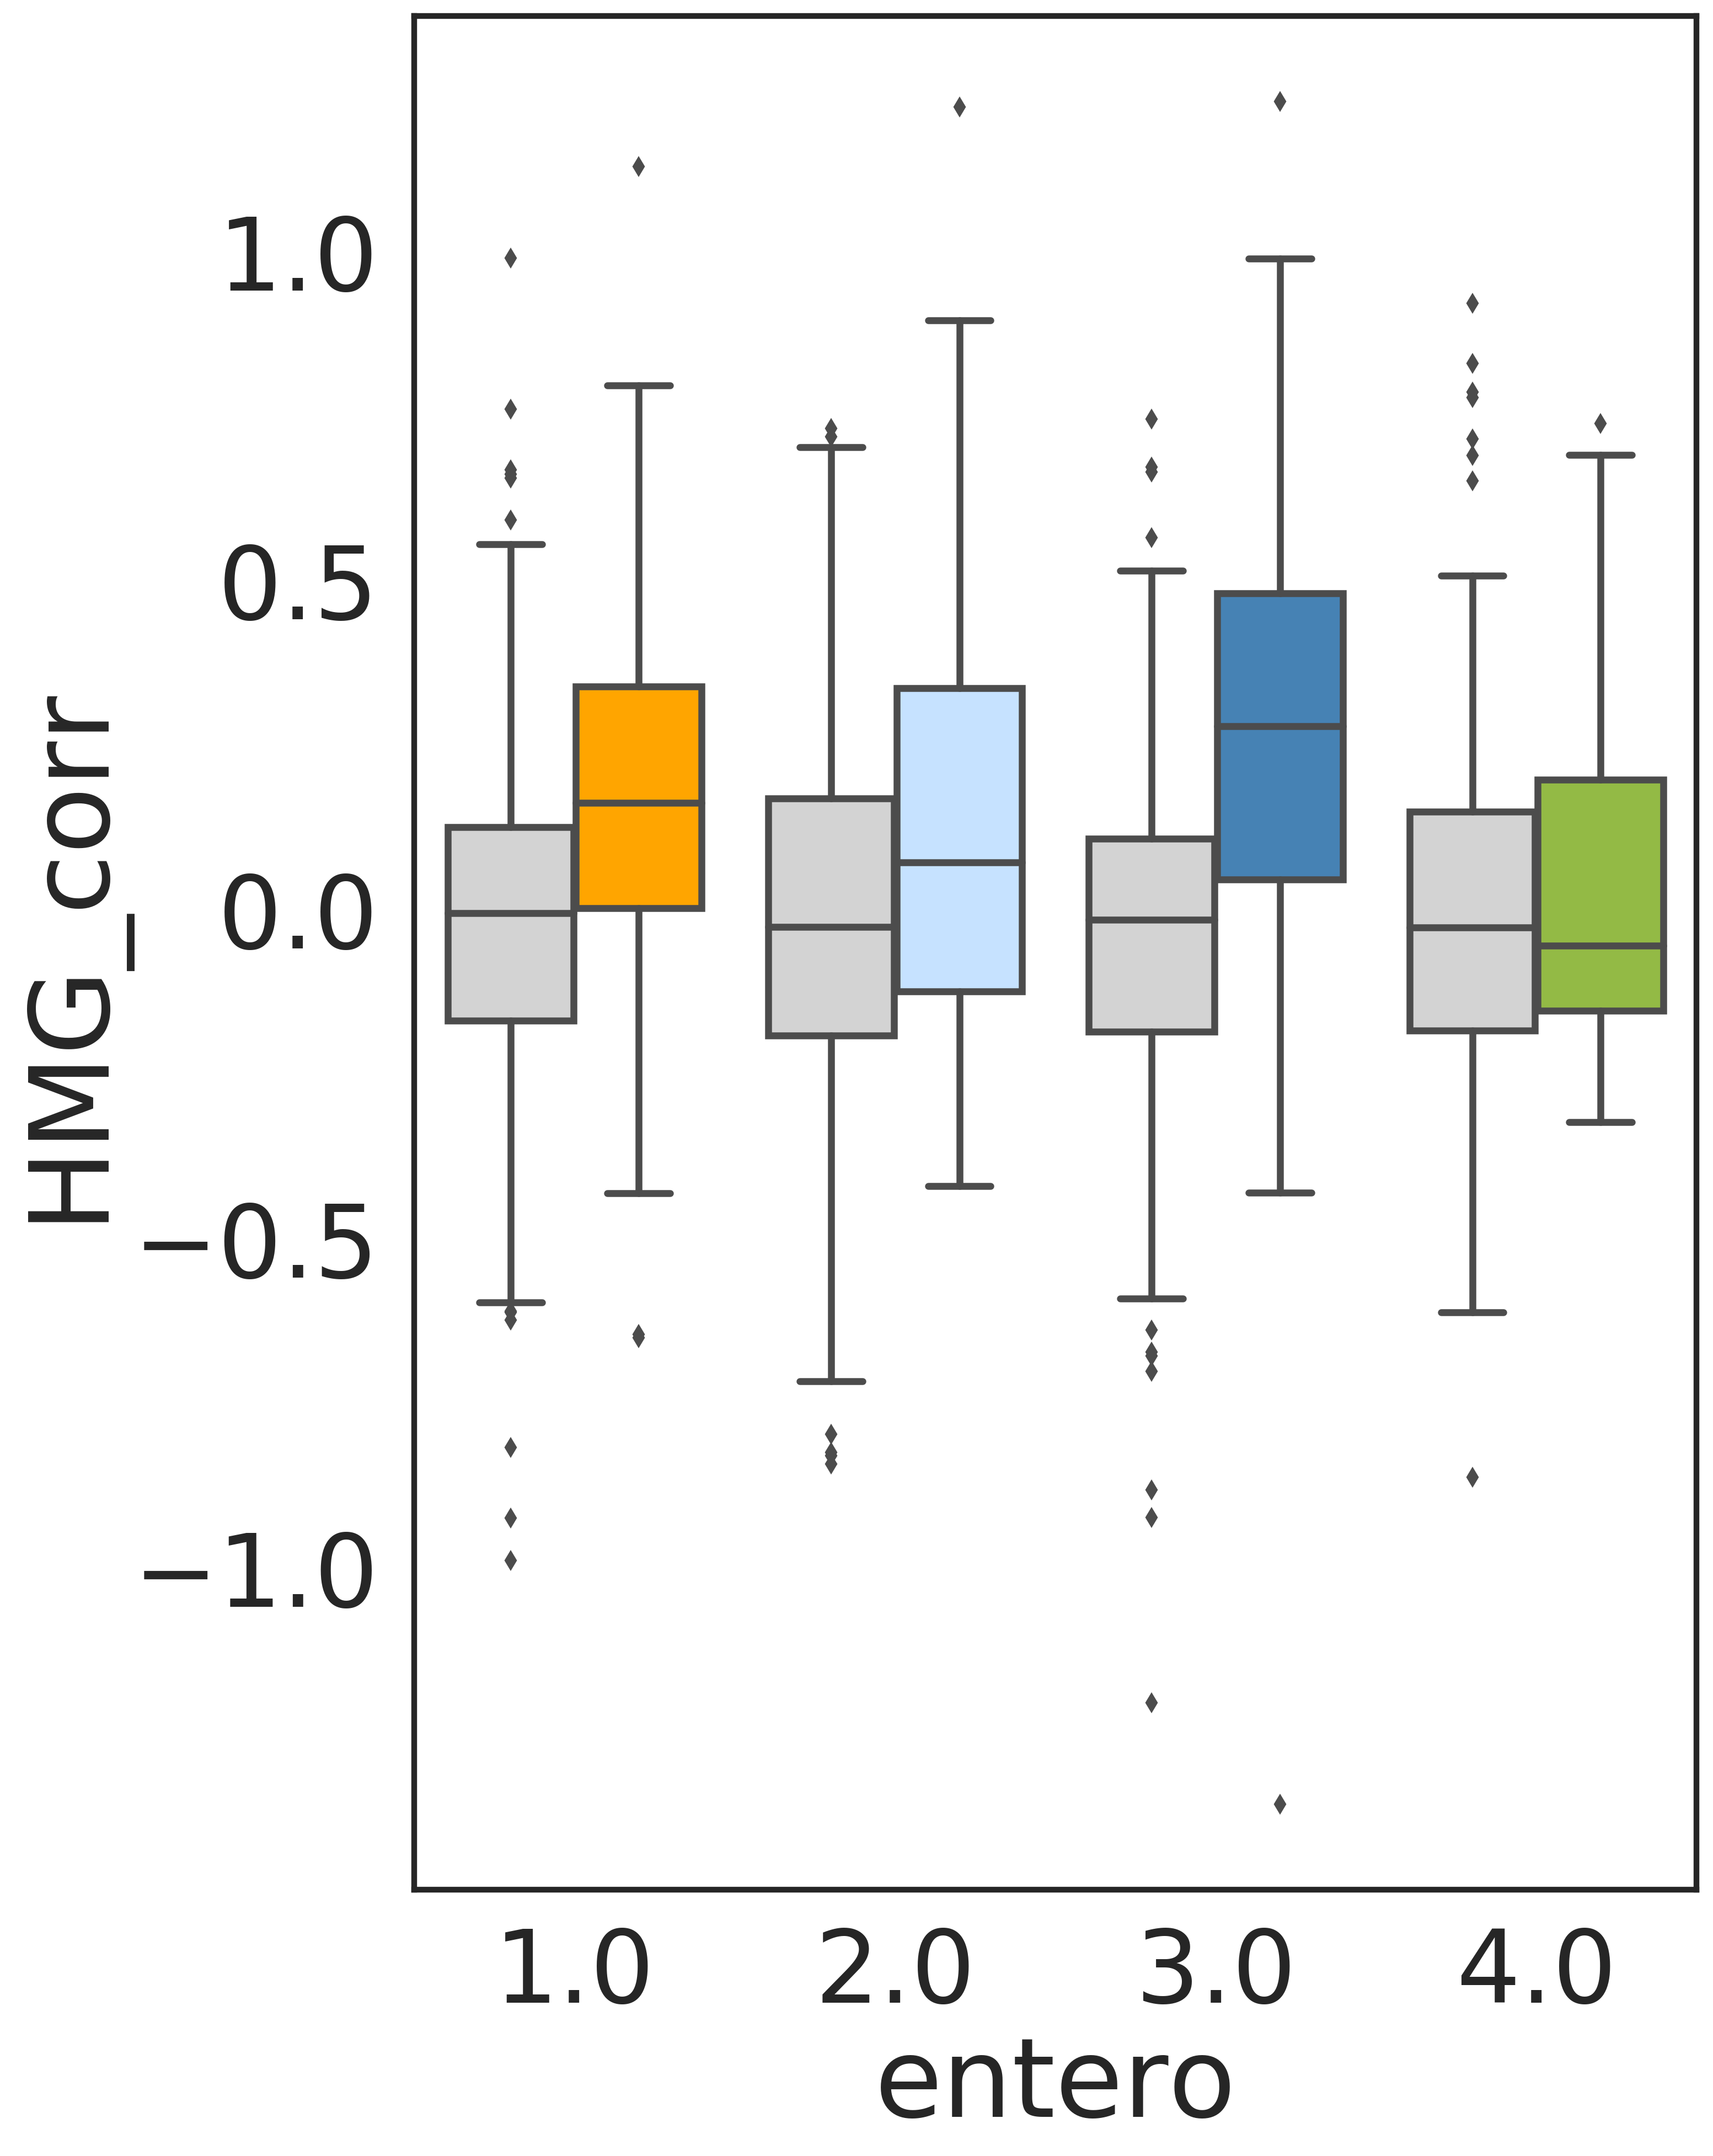

In [319]:
#Statistics and Visualization for Figure 3F
#log transform HMG for ANOVA analysis
df['log_HMG']=np.log(df['HMG'])
#generate HMG residuals (after adjusting for covariates)
df['HMG_corr']=smf.ols('log_HMG~chem_vendor+vendor_microbiome+sex+age+age_sq+BMI',data=df).fit().resid+df['log_HMG'].mean()
sns.set(font_scale=2.0,context='poster',font='Arial',style='white')
plt.figure(figsize=[10,15], dpi=300)
#generate Figure 3F
ax=sns.boxplot(df['entero'],(df['HMG_corr']),hue=df['statins_binary'],palette=['lightgrey','yellowgreen'])
# generate the right color scheme   
mybox = ax.artists[1]
mybox.set_facecolor('orange')
mybox2 = ax.artists[3]
mybox2.set_facecolor('#C6E2FF')
mybox3 = ax.artists[5]
mybox3.set_facecolor('#4682b4')
ax.legend_.remove()
#run unadjusted anova model
rez=smf.ols('log_HMG~C(entero, Sum)*C(statins_binary,Sum)',data=df).fit()
aov_table = sm.stats.anova_lm(rez, typ=3)
print('unadjusted ANOVA',aov_table)
#run covariate adjusted ANCOVA
rez=smf.ols('log_HMG~chem_vendor+vendor_microbiome+sex+age+age_sq+BMI+C(entero, Sum)*C(statins_binary,Sum)',data=df).fit()
aov_table = sm.stats.anova_lm(rez, typ=3)

print('Adjusted ANCOVA model')
aov_table

In [320]:
#covariate adjusted percent increase in HMG across enterotypes
df['HMG_corr_exp']=np.exp(df['HMG_corr'])
for y in [1,2,3,4]:
        d=df[df['entero']==y]
        print('enterotype',y,'percent increase relative to non-users',(d['HMG_corr_exp'][d['statins_binary']==1].mean()/d['HMG_corr_exp'][d['statins_binary']==0].mean())-1)       

enterotype 1 percent increase relative to non-users 0.23969090777141333
enterotype 2 percent increase relative to non-users 0.18408661126763293
enterotype 3 percent increase relative to non-users 0.36940829146024834
enterotype 4 percent increase relative to non-users 0.08252353957726188


In [321]:
#post-hoc within enterotype comparisons of statin users and non-users
for x in [1,2,3,4]:
    ttest=df[df['entero']==x]
    ttest=ttest[ttest['HMG_corr'].isna()==False]
    print(x)
    print(scipy.stats.ttest_ind(ttest['HMG_corr'][ttest['statins_binary']==0],ttest['HMG_corr'][ttest['statins_binary']==1]))
    print(ttest.groupby(by='statins_binary').size())

1
Ttest_indResult(statistic=-5.854815107789343, pvalue=8.21734206448606e-09)
statins_binary
0    484
1     68
dtype: int64
2
Ttest_indResult(statistic=-3.297402067837933, pvalue=0.0010544197227257898)
statins_binary
0    395
1     50
dtype: int64
3
Ttest_indResult(statistic=-7.3132748599932995, pvalue=1.570969883100497e-12)
statins_binary
0    314
1     66
dtype: int64
4
Ttest_indResult(statistic=-0.7968001773072333, pvalue=0.4269871777341605)
statins_binary
0    122
1     13
dtype: int64


In [322]:
#generating table 2 in the paper, statin*enterotype interaction effect p-values
#with different measures of glucose homeostasis as the dependent variable
df['log_LDL']=np.log(df['LDL'])
measure=[]
unadjusted_p=[]
unadjusted_f=[]
cov_adjusted_p=[]
cov_adjusted_f=[]
cov_diab_adjusted_f=[]
cov_diab_adjusted_p=[]
for x in ['HOMA_IR','insulin','glucose','hba1c']:
    df['response']=np.log10(df[x])
    rez=smf.ols('response~C(entero, Sum)*C(statins_binary,Sum)',data=df).fit()
    aov_table = sm.stats.anova_lm(rez, typ=3)
    measure.append(x)
    unadjusted_p.append(aov_table['PR(>F)'][3])
    unadjusted_f.append(aov_table['F'][3])
    rez=smf.ols('response~chem_vendor+vendor_microbiome+age_sq+BMI+HMG+LDL+sex+age+C(entero, Sum)*C(statins_binary,Sum)',data=df).fit()
    aov_table = sm.stats.anova_lm(rez, typ=3)
    cov_adjusted_p.append(aov_table['PR(>F)'][4])
    cov_adjusted_f.append(aov_table['F'][4])
    rez=smf.ols('response~vendor_microbiome+chem_vendor+age_sq+BMI+HMG+LDL+sex+age+diabetes+C(entero, Sum)*C(statins_binary,Sum)',data=df).fit()
    aov_table = sm.stats.anova_lm(rez, typ=3)
    cov_diab_adjusted_p.append(aov_table['PR(>F)'][5])
    cov_diab_adjusted_f.append(aov_table['F'][5])
Results=pd.DataFrame()
Results['measures']=measure
Results['unadjusted_interaction_pvalue']=unadjusted_p
Results['unadjusted_interaction_fvalue']=unadjusted_f
Results['cov_adjusted_interaction_pvalue']=cov_adjusted_p
Results['cov_adjusted_interaction_fvalue']=cov_adjusted_f
Results['cov_diab_adjusted_pvalue']=cov_diab_adjusted_p
Results['cov_diab_adjusted_fvalue']=cov_diab_adjusted_f
#save results to CSV file (presented in table 2)
Results.to_csv('interaction_metabolic_effects.csv')
Results

,measures,unadjusted_interaction_pvalue,unadjusted_interaction_fvalue,cov_adjusted_interaction_pvalue,cov_adjusted_interaction_fvalue,cov_diab_adjusted_pvalue,cov_diab_adjusted_fvalue
0,HOMA_IR,0.003682,4.516664,0.049500,2.618366,0.049329,2.621504
1,insulin,0.031652,2.950690,0.230859,1.434845,0.214891,1.492226
2,glucose,0.000246,6.445365,0.004114,4.436960,0.009203,3.856270
3,hba1c,0.000023,8.117625,0.000298,6.310804,0.017050,3.406754


In [323]:
#calcualte percent median difference between statin users and non-users across measures of glucose homeostasis
#Obtain p-value for the difference between groups using t-test table2
percent=[]
measure=[]
enterotype=[]
p_value=[]
for x in ['HOMA_IR','insulin','glucose','hba1c']:
    df['response']=np.log(df[x])
    df['response_corr']=smf.ols('response~chem_vendor+vendor_microbiome+age_sq+HMG+LDL+sex+age+BMI',data=df).fit().resid+df['response'].mean()   
    for y in [1,2,3,4]:
        d=df[df['entero']==y]
        measure.append(x)
        enterotype.append(y)
        percent.append((((d[x][d['statins_binary']==1].median())/(d[x][d['statins_binary']==0].median()))-1)*100)
        p_value.append(scipy.stats.ttest_ind(d['response_corr'][d['statins_binary']==0],d['response_corr'][d['statins_binary']==1])[1])
results_posthoc=pd.DataFrame()
results_posthoc['measure']=measure
results_posthoc['enterotype']=enterotype
results_posthoc['percent_change']=percent
results_posthoc['p_value']=p_value
#print results
results_posthoc

,measure,enterotype,percent_change,p_value
0,HOMA_IR,1,72.999314,7.189113e-07
1,HOMA_IR,2,20.825321,2.666988e-01
2,HOMA_IR,3,98.876539,1.175797e-04
3,HOMA_IR,4,28.571429,3.330740e-01
4,insulin,1,62.500000,5.572304e-06
5,insulin,2,19.285714,1.705641e-01
6,insulin,3,88.888889,9.088130e-04
7,insulin,4,22.222222,2.813876e-01
8,glucose,1,6.593407,9.650142e-04
9,glucose,2,4.494382,5.138082e-01


cov. unadjusted                                              sum_sq      df            F  \
Intercept                              4.902534e+06     1.0  4765.076008   
C(statins_binary, Sum)                 5.645018e+04     1.0    54.867412   
C(entero, Sum)                         3.082302e+03     3.0     0.998627   
C(statins_binary, Sum):C(entero, Sum)  1.007603e+04     3.0     3.264504   
Residual                               1.547386e+06  1504.0          NaN   

                                             PR(>F)  
Intercept                              0.000000e+00  
C(statins_binary, Sum)                 2.139379e-13  
C(entero, Sum)                         3.925675e-01  
C(statins_binary, Sum):C(entero, Sum)  2.067301e-02  
Residual                                        NaN  
cov. adjusted                                              sum_sq      df          F  \
Intercept                              2.384533e+03     1.0   2.555992   
chem_vendor                            8.

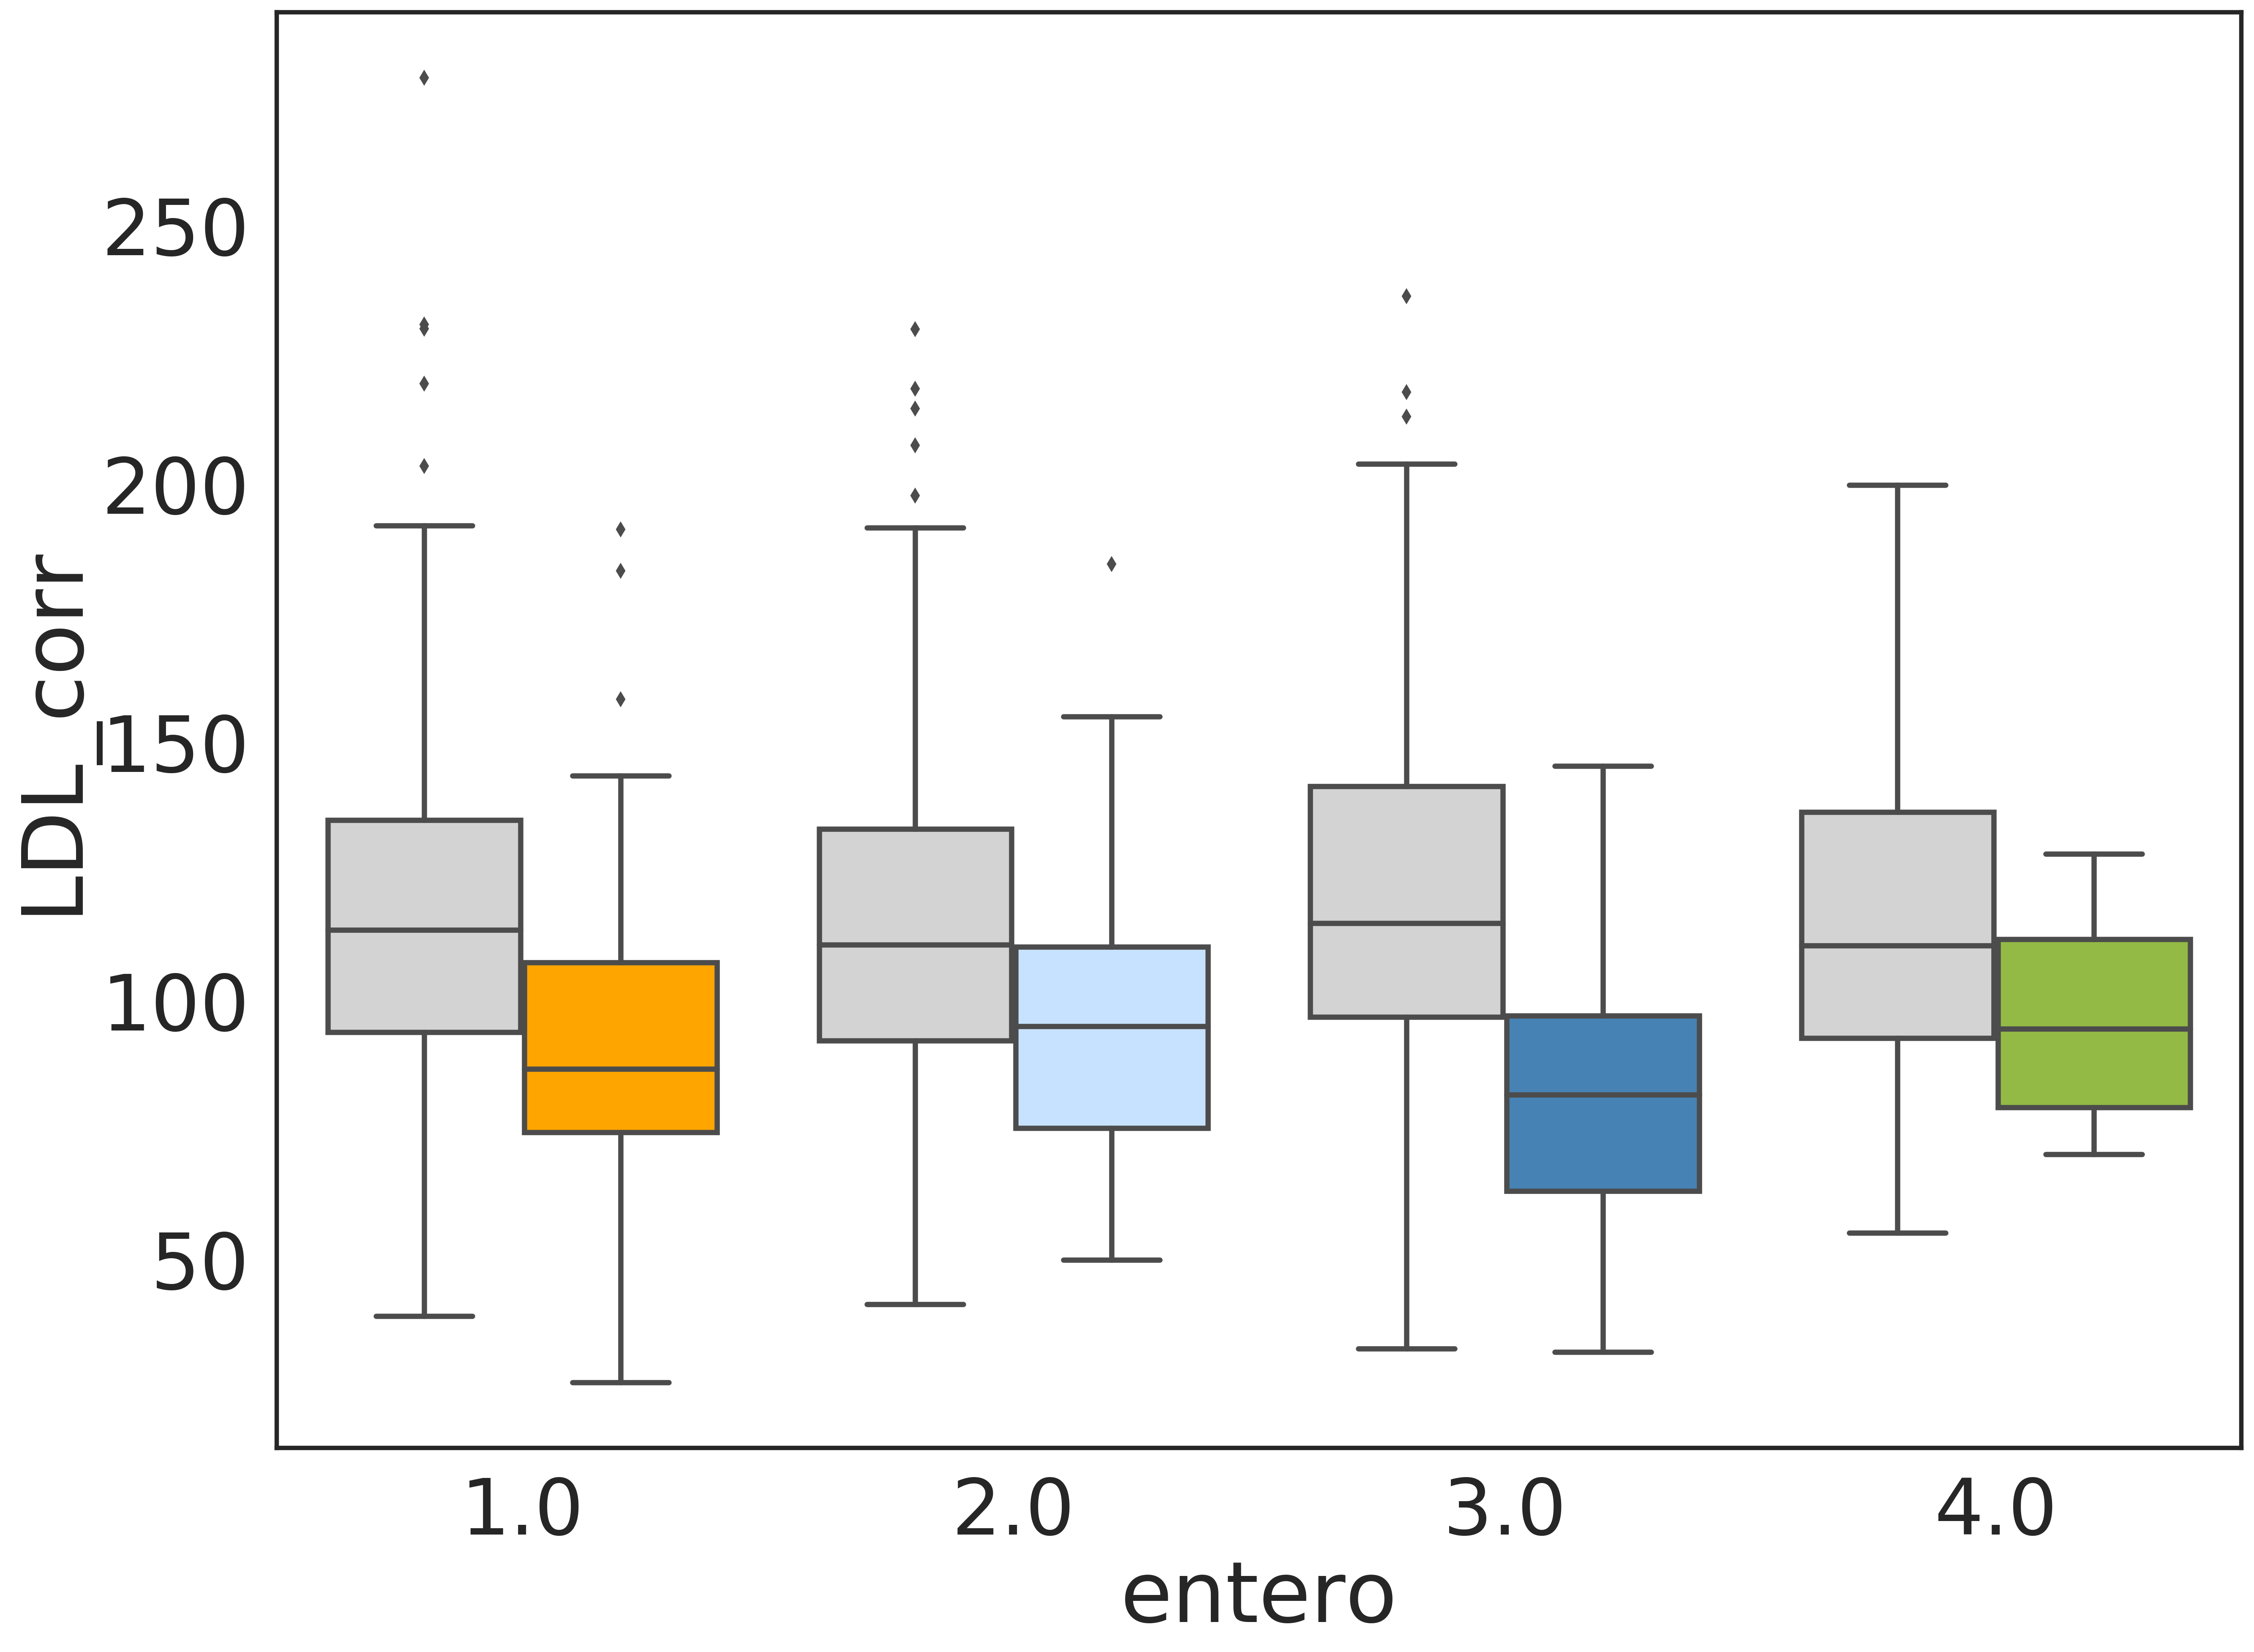

In [324]:
#Modeling Statin-by-enterotype interaction effects on LDL cholesterol levels

#Unadjusted ANOVA
rez=smf.ols('LDL~C(statins_binary,Sum)*C(entero, Sum)',data=df).fit()
aov_table = sm.stats.anova_lm(rez, typ=3)
print('cov. unadjusted',aov_table)
#adjusted ANOVA
rez=smf.ols('LDL~chem_vendor+vendor_microbiome+age_sq+sex+age+BMI+C(statins_binary,Sum)*C(entero, Sum)',data=df).fit()
aov_table = sm.stats.anova_lm(rez, typ=3)
print('cov. adjusted',aov_table)
#generate cov. adjusted variable (residual)
df['LDL_corr']=smf.ols('LDL~chem_vendor+vendor_microbiome+age_sq+sex+age+BMI',data=df).fit().resid+df['LDL'].mean()
sns.set(font_scale=2.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[20,15], dpi=300)
#plot figure
ax=sns.boxplot(df['entero'],(df['LDL_corr']),hue=df['statins_binary'],palette=['lightgrey','yellowgreen'])
# Select which box you want to change    
mybox = ax.artists[1]
# Change the appearance of that box
mybox.set_facecolor('orange')
mybox2 = ax.artists[3]
mybox2.set_facecolor('#C6E2FF')
mybox3 = ax.artists[5]
mybox3.set_facecolor('#4682b4')
ax.legend_.remove()
#print percent difference in LDL between statin users and non-users across enterotypes and corr. p-value
for x in [1,2,3,4]:
    ttest=df[df['entero']==x]
    ttest=ttest[ttest['LDL_corr'].isna()==False]
    print(x)
    print(scipy.stats.ttest_ind(ttest['LDL_corr'][ttest['statins_binary']==0],ttest['LDL_corr'][ttest['statins_binary']==1]))
    print(ttest.groupby(by='statins_binary').size())
    print('% decrease',1-(ttest['LDL_corr'][ttest['statins_binary']==1].mean()/ttest['LDL_corr'][ttest['statins_binary']==0].mean()))

In [326]:
from tableone import TableOne

In [327]:
#Generate table S1
columns = ['age','BMI','LDL','HOMA_IR','glucose','diabetes','sex','chem_vendor','vendor_microbiome','race']
categorical = ['diabetes','sex','chem_vendor','vendor_microbiome','race']
#df['test']=1
groupby = ['statins_binary']
nonnormal = ['HMG','HOMA_IR']
tableS1 = TableOne(df, columns, categorical, groupby, nonnormal,pval=False)
tableS1.to_csv('tableS1.csv')
tableS1

Grouped by statins_binary                              
                                          Missing              0              1
n                                                           1604            244
age                                             0    47.3 (10.9)    59.1 (10.1)
BMI                                             0     27.8 (6.5)     30.1 (6.2)
LDL                                             0   115.9 (32.8)    95.0 (28.8)
HOMA_IR                                         0  1.8 [1.3,2.8]  3.1 [2.0,5.1]
glucose                                         0    92.9 (16.5)   106.7 (35.9)
diabetes          False                       157    1451 (98.2)     174 (81.3)
                  True                                  26 (1.8)      40 (18.7)
sex               0                             0     558 (34.8)     125 (51.2)
                  1                                  1046 (65.2)     119 (48.8)
chem_vendor       LCA                           0    1141 (71.1)     154 (63.1)
                  Quest                               463 (28.9)      90 (36.9)
vendor_microbiome 0.0                         110     689 (45.8)     112 (48.1)
                  1.0                                 816 (54.2)     121 (51.9)
race              0.0                          72     305 (19.9)      37 (15.2)
                  1.0                                1227 (80.1)     207 (84.8)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age, glucose.
[2] Warning, Tukey test indicates far outliers in: BMI, HOMA_IR, LDL, glucose.
[3] Warning, test for normality reports non-normal distributions for: BMI, HOMA_IR, LDL, glucose.

In [328]:
#Generate table S1
df['all']=1
columns = ['age','BMI','LDL','HOMA_IR','glucose','diabetes','sex','chem_vendor','vendor_microbiome','race']
categorical = ['diabetes','sex','chem_vendor','vendor_microbiome','race']
nonnormal = ['HMG','HOMA_IR']
groupby=['all']
tableS1 = TableOne(df, columns, categorical, groupby,nonnormal,pval=False)
tableS1.to_csv('tableS1_whole.csv')
tableS1

Grouped by all               
                               Missing              1
n                                                1848
age                                  0    48.8 (11.5)
BMI                                  0     28.1 (6.5)
LDL                                  0   113.2 (33.1)
HOMA_IR                              0  1.9 [1.3,3.1]
glucose                              0    94.7 (20.7)
diabetes          False            157    1625 (96.1)
                  True                       66 (3.9)
sex               0                  0     683 (37.0)
                  1                       1165 (63.0)
chem_vendor       LCA                0    1295 (70.1)
                  Quest                    553 (29.9)
vendor_microbiome 0.0              110     801 (46.1)
                  1.0                      937 (53.9)
race              0.0               72     342 (19.3)
                  1.0                     1434 (80.7)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age, glucose.
[2] Warning, Tukey test indicates far outliers in: BMI, HOMA_IR, LDL, glucose.
[3] Warning, test for normality reports non-normal distributions for: BMI, HOMA_IR, LDL, glucose.

In [329]:
#obesity prevalance in the cohort
df[df['BMI']>=30].shape[0]/df.shape[0]

0.3116883116883117

0

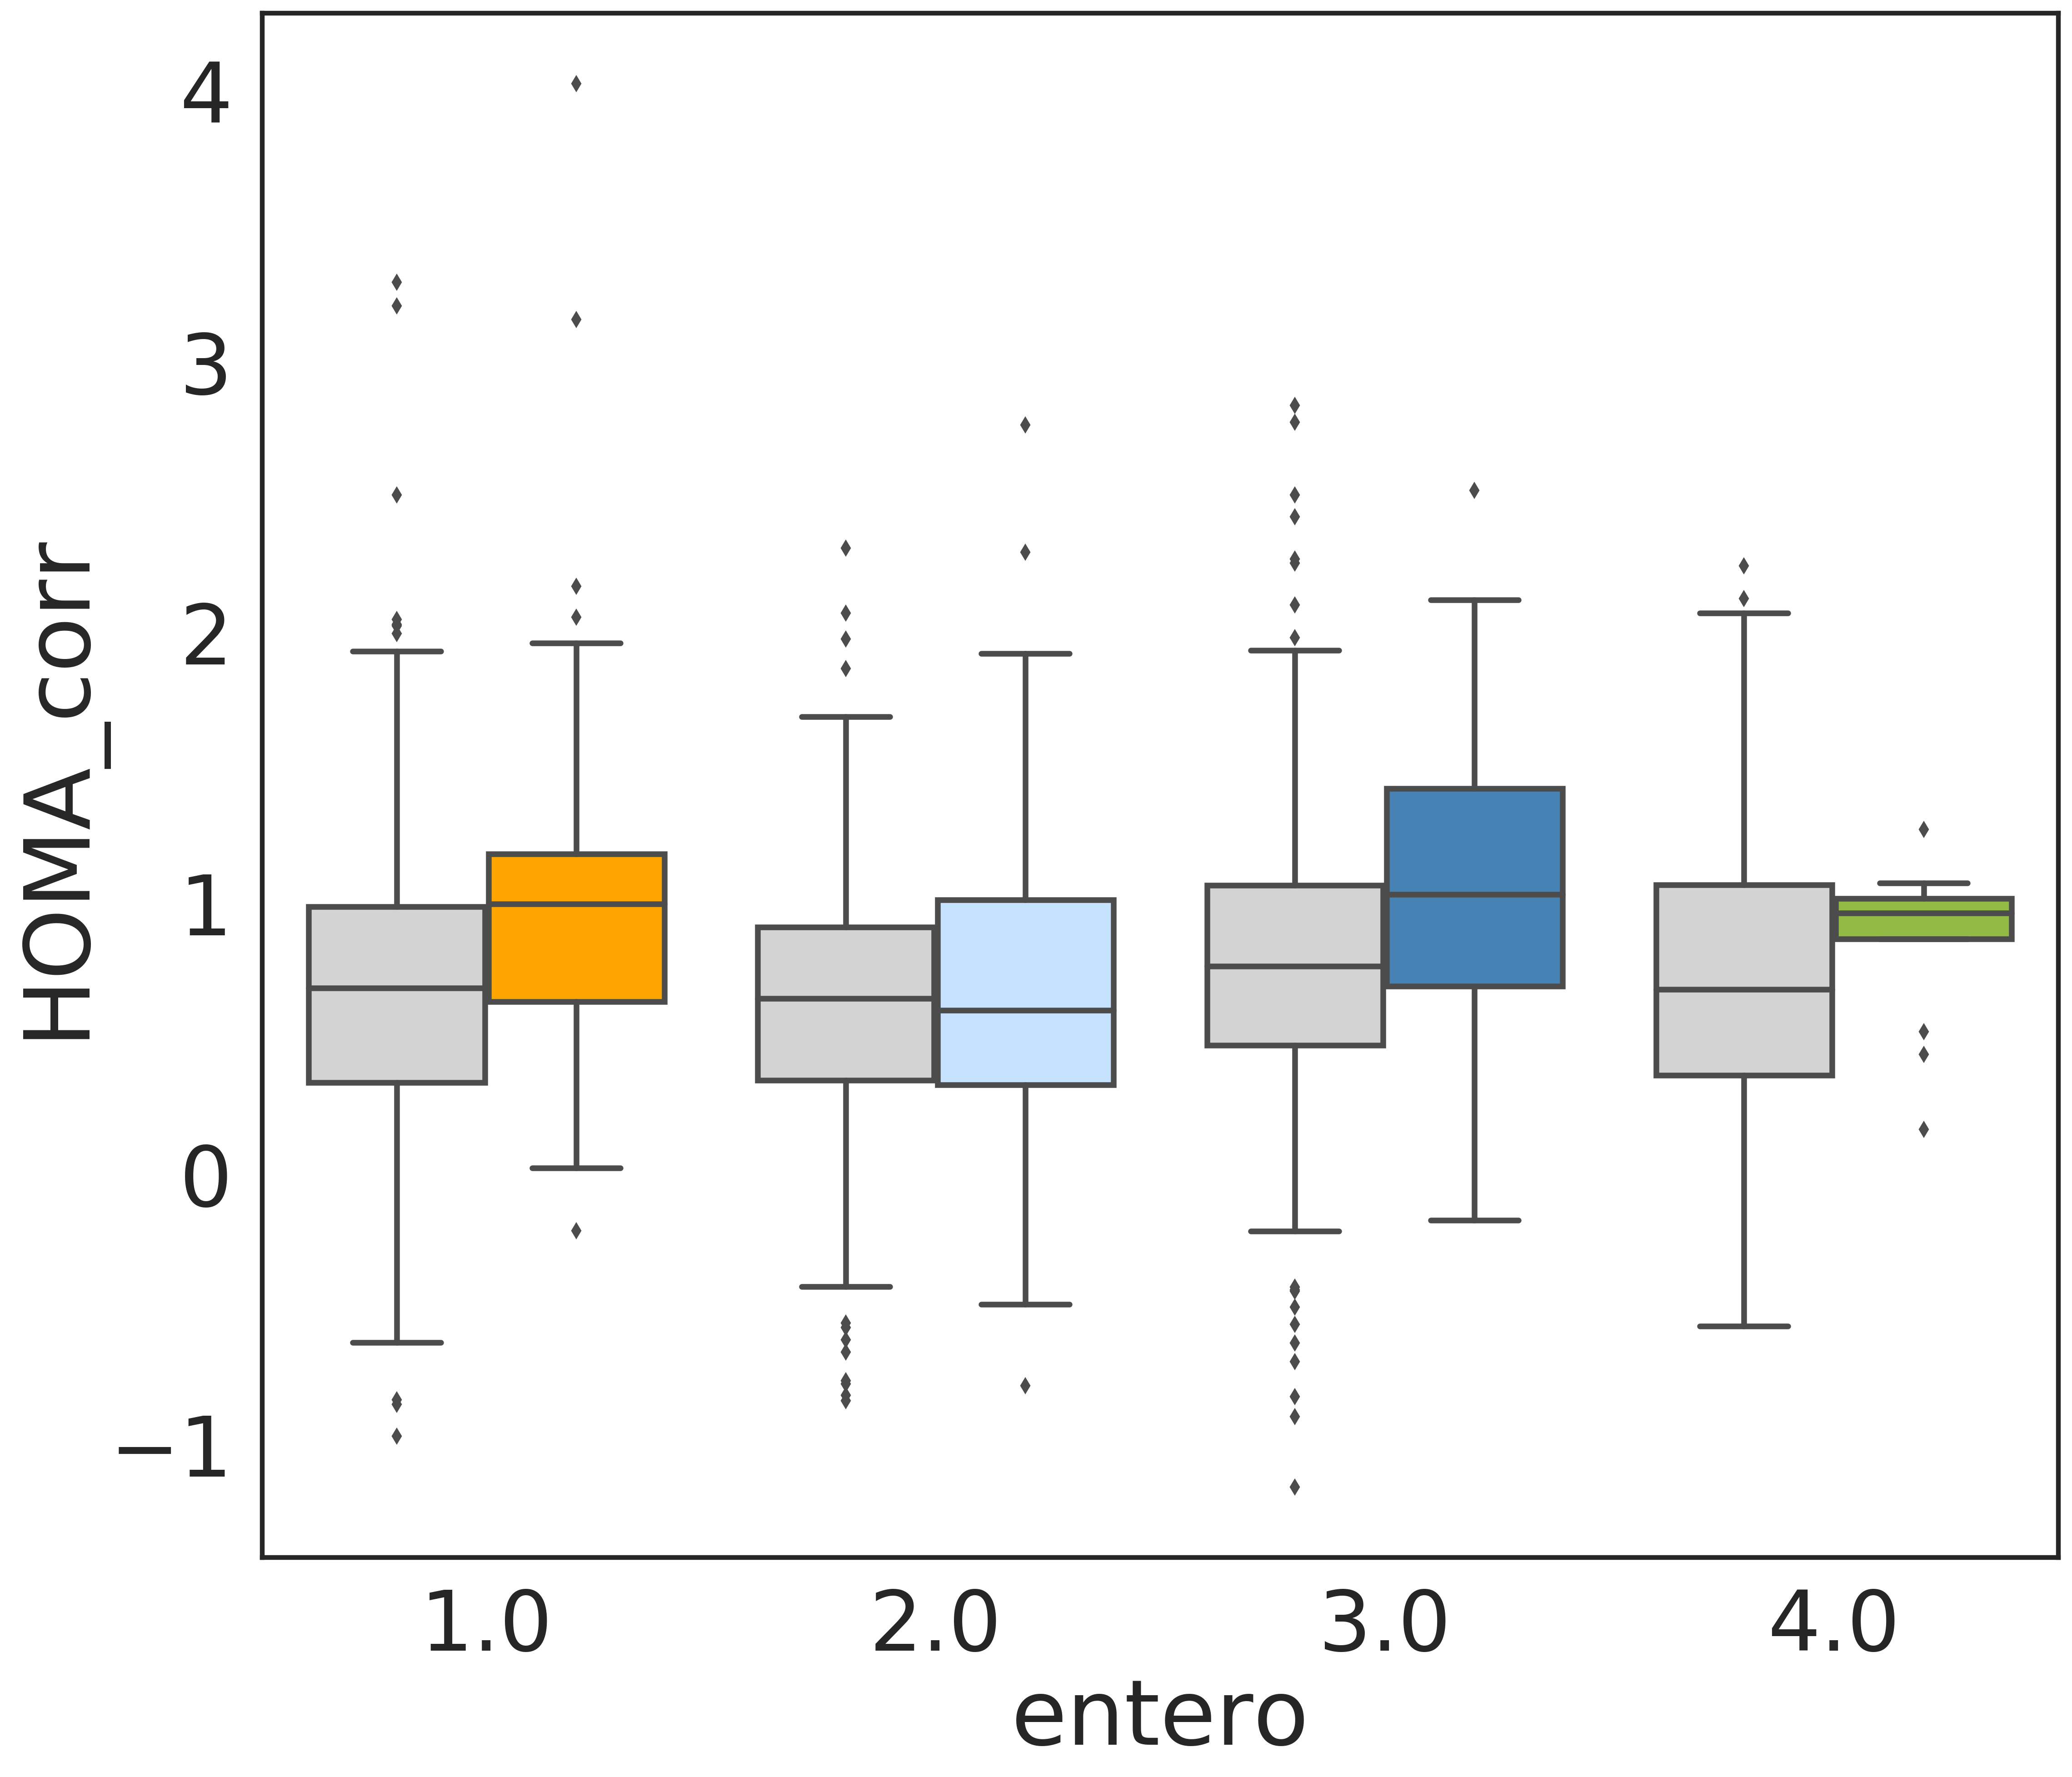

In [330]:
sns.set(font_scale=2.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[17,15], dpi=300)
df['log_HOMA']=np.log(df['HOMA_IR'])
df['HOMA_corr']=smf.ols('log_HOMA~chem_vendor+vendor_microbiome+age_sq+HMG+LDL+sex+age+BMI',data=df).fit().resid+df['log_HOMA'].mean()
ax=sns.boxplot(df['entero'],(df['HOMA_corr']),hue=df['statins_binary'],palette=['lightgrey','yellowgreen'])
# Select which box you want to change    
mybox = ax.artists[1]
# Change the appearance of that box
mybox.set_facecolor('orange')
mybox2 = ax.artists[3]
mybox2.set_facecolor('#C6E2FF')
mybox3 = ax.artists[5]
mybox3.set_facecolor('#4682b4')
ax.legend_.remove()
d=df[df['entero'].isnull()==False]
d['HOMA_corr'].isnull().sum()

In [331]:
#investigating obesity Bac.2 association using logistic regression
bac2=[]
for x in df['entero']:
    if x==3:
        bac2.append(1)
    elif x in [1,2,4]:
        bac2.append(0)
    else:
        bac2.append(np.NaN)
df['bac2']=bac2
ob=[]
for x in df['BMI']:
    if x>=30:
        ob.append(1)
    elif x<30:
        ob.append(0)
df['ob']=ob
print(df[df['entero'].isnull()==False].groupby(by='ob').size())
formula='bac2~age+age_sq+sex+vendor_microbiome+ob'
res=sm.GLM.from_formula(formula,data=df, family=sm.families.Binomial()).fit()
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print('Bac2~obesity',np.exp(conf))
print(res.pvalues)
formula='bac2~age+age_sq+sex+LDL+vendor_microbiome+statins_binary'
res=sm.GLM.from_formula(formula,data=df[df['ob']==1], family=sm.families.Binomial()).fit()
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print('Bac2~statin_use among obese',np.exp(conf))
res.pvalues

ob
0    1050
1     462
dtype: int64
Bac2~obesity                          5%       95%  Odds Ratio
Intercept          0.130514  2.984029    0.624066
age                0.893283  1.015427    0.952399
age_sq             0.999861  1.001131    1.000496
sex                1.002421  1.658449    1.289366
vendor_microbiome  1.025368  1.680331    1.312615
ob                 1.397802  2.306011    1.795368
Intercept            0.554803
age                  0.135773
age_sq               0.125721
sex                  0.047839
vendor_microbiome    0.030868
ob                   0.000005
dtype: float64
Bac2~statin_use among obese                          5%        95%  Odds Ratio
Intercept          0.011191  11.666978    0.361336
age                0.907324   1.210236    1.047891
age_sq             0.997910   1.000859    0.999383
sex                0.863941   2.137117    1.358802
LDL                0.985914   0.999395    0.992631
vendor_microbiome  0.758358   1.849166    1.184200
statins_binary     1.

Intercept            0.565840
age                  0.524414
age_sq               0.412329
sex                  0.184513
LDL                  0.032792
vendor_microbiome    0.457163
statins_binary       0.013067
dtype: float64

In [67]:
#Associations reported in Table 1
df['Shannon_scaled']=(df['Shannon']-df['Shannon'].mean())/df['Shannon'].std()
df['Observed_scaled']=(df['Observed']-df['Observed'].mean())/df['Observed'].std()
bac2=[]
for x in df['entero']:
    if x==3:
        bac2.append(1)
    elif x in [1,2,4]:
        bac2.append(0)
    else:
        bac2.append(x)
df['bac_2']=bac2
targets=[100,70]
cut_off=[]
measure=[]
p=[]
OR=[]
lower=[]
diab=[]
upper=[]
for x in targets:
    target=[]
    for y in df['LDL']:
        if y<x:
            target.append(1)
        else:
            target.append(0)
    df['target']=target
    for z in ['Shannon_scaled','Observed_scaled','bac_2']:
        df['response']=df[z]
        formula='target~chem_vendor+age+BMI+sex+response'
        res=sm.GLM.from_formula(formula,data=df[df['statins_binary']==1], family=sm.families.Binomial()).fit()
        params = res.params
        conf = res.conf_int()
        conf['Odds Ratio'] = params
        conf.columns = ['5%', '95%', 'Odds Ratio']
        conf=np.exp(conf)
        conf['p-value']=res.pvalues[5]
        print(z,x,conf.iloc[5:])
        cut_off.append(x)
        measure.append(z)
        lower.append(conf.iloc[5,0])
        upper.append(conf.iloc[5,1])
        p.append(res.pvalues[5])
        OR.append(conf.iloc[5,2])
        diab.append(0)
results_Logit=pd.DataFrame()
results_Logit['measure']=measure
results_Logit['LDL_cut_off']=cut_off
results_Logit['p-value']=p
results_Logit['OR']=OR
results_Logit['5%']=lower
results_Logit['95%']=upper

Shannon_scaled 100                5%       95%  Odds Ratio   p-value
response  0.49481  0.952689    0.686586  0.024451
Observed_scaled 100                 5%       95%  Odds Ratio  p-value
response  0.491119  0.959348    0.686407   0.0276
bac_2 100                 5%       95%  Odds Ratio   p-value
response  1.089588  4.788678    2.284225  0.028732
Shannon_scaled 70                 5%       95%  Odds Ratio  p-value
response  0.507623  0.980515    0.705501  0.03779
Observed_scaled 70                 5%       95%  Odds Ratio   p-value
response  0.474401  1.008297    0.691619  0.055237
bac_2 70                 5%       95%  Odds Ratio   p-value
response  1.659949  7.617182    3.555859  0.001099


In [68]:
for x in targets:
    target=[]
    for y in df['LDL']:
        if y<x:
            target.append(1)
        else:
            target.append(0)
    df['target']=target
    for z in ['Shannon_scaled','Observed_scaled','bac_2']:
        df['response']=df[z]
        formula='target~chem_vendor+vendor_microbiome+age+BMI+diabetes+sex+response'
        res=sm.GLM.from_formula(formula,data=df[df['statins_binary']==1], family=sm.families.Binomial()).fit()
        params = res.params
        conf = res.conf_int()
        conf['Odds Ratio'] = params
        conf.columns = ['5%', '95%', 'Odds Ratio']
        conf=np.exp(conf)
        conf['p-value']=res.pvalues[7]
        print(z,x,conf.iloc[7:])
        cut_off.append(x)
        measure.append(z)
        lower.append(conf.iloc[7,0])
        upper.append(conf.iloc[7,1])
        p.append(res.pvalues[7])
        OR.append(conf.iloc[7,2])
        diab.append(1)
results_Logit=pd.DataFrame()
results_Logit['measure']=measure
results_Logit['LDL_cut_off']=cut_off
results_Logit['p-value']=p
results_Logit['OR']=OR
results_Logit['5%']=lower
results_Logit['95%']=upper
results_Logit['diab_adjustment']=diab
results_Logit

Shannon_scaled 100                 5%       95%  Odds Ratio   p-value
response  0.490977  1.012822    0.705175  0.058625
Observed_scaled 100                 5%       95%  Odds Ratio   p-value
response  0.460546  0.985052    0.673544  0.041588
bac_2 100                 5%       95%  Odds Ratio   p-value
response  0.982675  4.788455    2.169215  0.055275
Shannon_scaled 70                 5%       95%  Odds Ratio   p-value
response  0.413808  0.883186    0.604541  0.009262
Observed_scaled 70                 5%       95%  Odds Ratio   p-value
response  0.397347  0.960516    0.617785  0.032446
bac_2 70                 5%        95%  Odds Ratio   p-value
response  1.830983  10.249188    4.331985  0.000848


,measure,LDL_cut_off,p-value,OR,5%,95%,diab_adjustment
0,Shannon_scaled,100,0.024451,0.686586,0.494810,0.952689,0
1,Observed_scaled,100,0.027600,0.686407,0.491119,0.959348,0
2,bac_2,100,0.028732,2.284225,1.089588,4.788678,0
3,Shannon_scaled,70,0.037790,0.705501,0.507623,0.980515,0
4,Observed_scaled,70,0.055237,0.691619,0.474401,1.008297,0
5,bac_2,70,0.001099,3.555859,1.659949,7.617182,0
6,Shannon_scaled,100,0.058625,0.705175,0.490977,1.012822,1
7,Observed_scaled,100,0.041588,0.673544,0.460546,0.985052,1
8,bac_2,100,0.055275,2.169215,0.982675,4.788455,1
9,Shannon_scaled,70,0.009262,0.604541,0.413808,0.883186,1
